In [1]:
#hide
!pip install -Uqq fastbook kaggle waterfallcharts treeinterpreter dtreeviz
import fastbook
fastbook.setup_book()

In [2]:
#For unzipping
#import zipfile
#with zipfile.ZipFile('../bluebook/bluebook-for-bulldozers.zip', 'r') as zip_ref:
#    zip_ref.extractall('../bluebook/')

In [1]:
#hide
from fastbook import *
from kaggle import api
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from fastai.tabular.all import *
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from dtreeviz.trees import *
from IPython.display import Image, display_svg, SVG

pd.options.display.max_rows = 20
pd.options.display.max_columns = 8

# Tabular Modeling Deep Dive

Tabular modeling veriyi tablo şeklinde alır (like CSV). Temel amaç ise istenilen bir column'un değerlerini diğer column değerlerine bakarak, tahmin etmektir.

Bu bölümde sadece deep learning'e bakmayacağız, random forests gibi daha genel machine learning tekniklerine de bakacağız, bu tür yaklaşımlar problemine göre bize daha iyi sonuçlar verebilir.

Veriyi nasıl preprocess edeceğimize ve temizleyeceğimize bakacağız, ayrıca training sonuçlarını nasıl interpret edeceğimize de göz atacağız.

Ancak herşeyden önce embeddings kullanarak, categorical columnları modele nasıl besleyeceğimize bakacağız. Modelimiz input olarak bizden sayısal veriler bekliyor olacak, bu durumda categorical inputları önce embedding layers'dan geçirip sonra modele beslemeliyiz.

## Categorical Embeddings

Tabular data için bazı columnlar "yaş" gibi numerical data içeririken bazı columnlar ise "cinsiyet" gibi categorical data içerebilir. 

Numerical data doğrudan (veya opsiyonel preprocessingden sonra) modele beslenebilirken, categorical data önce modelin anlamlandırabileceği numeric değerlere çevrilmek zorundadır.

**Continous Variables:** "Yaş" gibi doğrudan modele beslenebilecek, toplanıp çarpılabilecek ve toplanıp çarpılınca anlamlı olan değişken tipi.

**Categorical Variables:** "Movie ID" gibi discrete levels içeren, doğrudan toplanıp çarpılamayan, veya toplanıp çarpıldığında bir anlam ifade etmeyen değişken tipi.

2015'te Kaggle'da Rossman sales competition oldu. Yarışmacıları Almanya'daki farklı stores için değişik bilgiler verildi ve farklı günler için satış sayıları tahmini istendi.

Amaç, firmanın stock yönetimini en verimli şekilde yapabilmesiydi. Ayrıca yarışmacılar public şekilde paylaştığı sürece ekstra data kullanmakta da özgürdü.

Gold medalistslerden bir tanesi deep learning kullandı, bu deep learning'in tabular data için kullanıldığı ilk örneklerden biridir. Deep learning kullanıldığı için çok daha az feature engineering gerekiyordu, bu yüzden de daha az domain knowledge ile de iş halledilebiliyordu, çünkü feature engineering'i yapan deep learning algoritması oluyor.

"Entitity Embedding of Categorical Variables" paper'ı onların yaklaşımını gösteriyor. Kitabın online-only chapterında bu yaklaşımın sıfırdan nasıl gerçeklenebildiği gösterilmiş.

Entity embeddings'in farklı yararları var:

    - One-got encoding ile kıyaslandığında sadece memory usage'ı azaltamkla ve neural networks'u hızlandırmakla kalmıyor, bunun yanında benzer değerleri birbirine yakın olarak atayarak, categorical variables hakkında bilgiler ediniyor. Bu bilgiler categorical datayı visualizing veya data clustering için kullanılabilir. Özellikle çok fazla high cardinality features'ın olduğu datasets için diğer methodlar overfit etmeye meyilli oluyor. 
    
    - Burada high cardinality'den kastımız şu, 3-5 farklı seçenekli bir categorical variable değil de 3000-5000 seçenekli olduğunu düşün, bu high cardinality oluyor, bunlardan 5 tane olsa ve biz one-hot encoding kullanıyor olsak 3 variable'ı temsil etmek için modele 15000 input beslemek zorunda kalacağız, bu durumda modelin overfit etmesi çok yüksek olasılık. 
    
    - Çünkü modelin böylesi geniş bir uzayda yapacağı tahminin genelleştirilebilir olması neredeyse imkansız, bunu şöyle düşün, 100D bir uzayda 2 datapoint olsun linear regression ile bir doğru uyduralım, çok büyük ihtimalle overfit edeceğiz, çünkü uzay çok büyük henüz 2 data gördük, genelleme yapamk çok zor, ancak 2D eksende 2 data point ile aynı işlemi yaparsak, overfit riskimiz daha düşük.
    

Zateb collaborative filtering modelimizi build ederken, embeddings'in yukarıdaki yararlarını farketmiştik. Ancak bu embedding fikri ve embeddings içerisinde kategorik veriler hakkında bilgi edinme fikri collaborative filtering'i domine edecek çok daha önemli bir fikir.
    
Embedding layer'ın one-hot-encoded input layer'ın hemen sonrasına ordinary bir linear layer yerleştirmekle eşdeğer olduğunu da biliyoruz. Aşağıda bu gösterilmiş, dense layer ile linear layer aynı şey oluyor. One-hot encoding layers input'ları represent ediyor.

<img alt="Entity embeddings in a neural network" width="600" caption="Entity embeddings in a neural network (courtesy of Cheng Guo and Felix Berkhahn)" id="entity_emb" src="../images/att_00018.png">

Yani embedding layer aslında bir başka linear layer o kadar. Yaptığı işlem de basitçe bir lookup'tan ibaret. Back propagation ile bu işlemin türevi de alınabiliyor ve türev 1 çıkıyor, böylece backpropagation yapılırken, one-hot encoding'lerin yani inputların değeri değişmiyor, en son embedding'ler değişiyor, o kadar.

Biz linear layers'ı train etmeyi zaten biliyoruz, yukarıdaki şekilde görüyoruz ki embedding layer is just another layer. Zaten collaborative filtering modelini yaratırken, bunu görmüştük.

Rossman sale prediction problemi için, embedding yaklaşımını kullanan authors, eğitimden sonra embedding weights'i incelediler. Aşağıda bunu görüyoruz, burada önemli nokta şu, embedding yaklaşımı ile categorical variables'ı aldık ve continious ve meaningful variables'a çevirdik, bu çok değerli bir şey.


<img alt="State embeddings and map" width="800" caption="State embeddings and map (courtesy of Cheng Guo and Felix Berkhahn)" id="state_emb" src="../images/att_00015.png">

Şuna bakar mısın, model satış verilerini tahmin etmeye çalışırken, şehir categorical variables'ı için öyle embeddings oluşturuyor ki, bu embeddings'leri 2D yazdırınca harikatadaki konumları elde ediyoruz. Bu inanılmaz bir şey!!!

Embedding distance'lara baktığımız zaman da gerçek distance'ları yakın olduğunu görürüz.

Bunun yanında, gün hafta ve ay verileri de categorical variables. Bunlar için de embedding layers kullanırız, aşağıdaki grafiklerde günleri ve ayları plot ettirdiğimizi görebilirsiniz, bunlar arasındaki ilişkilere bakıldığında, takvim üzerinde birbirine yakın olan gün veya ayların, embedding vectorlerinin de birbirine görece yakın olduğunu görürürüz.

<img alt="Date embeddings" width="900" caption="Date embeddings" id="date_emb" src="../images/att_00017.png">

Sonuç olarak embeddings sayesinde categorical variables'ı continious variables'a çevirebiliyoruz, böylece modele besleyebiliyoruz, bunun yanında embeddings catergorical variables hakkında insights da öğrenir.

Tüm inputu continious variables şeklinde ifade ettikten sonra bunları concatenate edebiliriz, böylece bu concatenated input'u dense layer'a besleyerek sanki sıradan bir continious inputmuş gibi davranabiliriz, aşağıdaki grafikte google play'in bu yaklaşımla oluşturduğu bir recommendation system görünüyor:

<img alt="The Google Play recommendation system" width="800" caption="The Google Play recommendation system" id="google_recsys" src="../images/att_00019.png">

Deep learning modeli inages, sounds, nlp, gibi problemlerde iyi çalışır, collaborative filtering için de deep learning'in çalışacağını görmüştük. 

Fakat tabular data'yı analiz etmek için deep learning ile başlamak çok doğru değil, başlangıç için daha klasik ML yöntemleri daha mantıklı olabilir. Şimdi bunları inceleyelim:

## Beyond Deep Learning

Modern ML bir kaç temel tekniğe damıtılabilir. Son çalışmalar gösteriyor ki dataset'lerin çok büyük bir bölümü aşağıdaki iki yaklaşımla modellenebiliyor:

1. Ensembles of decision trees (i.e., random forests and gradient boosting machines), mainly for structured data (such as you might find in a database table at most companies)
1. Multilayered neural networks learned with SGD (i.e., shallow and/or deep learning), mainly for unstructured data (such as audio, images, and natural language)

Unstructured data için deep learning neredeyse her zaman üstün gelirken, structured data için yukarıdaki iki yaklaşım kafa kafaya gider, ancak "ensembles of decision trees" daha hızlı train edilebilir, daha kolay interpret edilebilir, GPU gerektirmez, ve daha az hyperparameter tuning gerektirir, ve deep learning'den daha eski olduğu için bu konuda daha çok tool ve documentation var.

Yani özetle, unstructured data için iki yöntemin performansı yakın olsa da decision trees'in uygulanması ve sonuçların interpretation'ı daha basit. 

Ayrıca modeli interpret etmek de decision tree ensembles yaklaşımında daha kolay. Örneğin predictions için hangi columnların daha önemli olduğunu anlamak, veya columnların dependent variable ise nasıl bağlantılı olduğunu veya birbirleri ile nasıl bağlantılı olduğunu vesaire anlamak decision tree ensembles için mümkün, bu analizleri bazı tool veya methodlarla yapabiliriz.

İşte bu yüzden tabular datasets için ilk olarak ensembles of decision trees yaklaşımı kullanmak daha mantıklı. Bu kuralı bozabilecek bazı durumlar var onlar da şunlar:

- Eğer problem için önemli high-cardinality categorical variables. Burada "cardinality" refers to the number of discrete levels representing categories, so a high-cardinality categorical variable is something like a zip code, which can take on thousands of possible levels).
- Ya da bazı columnlar text data gibi neural network ile daha iyi anlaşılabilecek data'lardan oluşuyorsa. 

Bu durumlarda deep learning kullanmak daha mantıklı olabilir, ancak pratikte yine önce DTE kullanmak göz çıkarmaz, iki yaklaşımı da deneriz ve sonuca bakarız. 

Örneğin bir önceki kısımdaki collaborative filtering örneği için 2 tane high-cardinality categorical variables vardı, user and movie, bu durumda deep learning'in daha iyi çalışması beklenir.

Öyle ya da böyle decision tree ensembles yaklaşımın nasıl çalıştığını anlamamız şart!

Şimdiye kadar bolca PyTorch ve fastai kullandık. Bu libraries çokça matrix multiplication yapılan derivative alınan durumlarda yani deep learning modellerinde işe yarar.

Ancak decision trees yaklaşımı matrix multiplication veya derivatie operation'ına dayanmaz bu yüzden PyTorch kullanmak gereksiz.

Onun yerine scikit-learn kullanacağız. Scikit-learn ML modelleri için kullanılan popular bir kütüphane. 

Ayrıca burada tabular data processing ve querying kullanıcak bu yüzden de Pandas gerekli olacak, son olarak da NumPy gerekli olacak çünkü sklearn ve Pandas NumPy üzerine kurulu.

Elbette burada bu kütüphanelerind detayına girilmeyecek, sadece önemli noktalara dokunulacak.

## The Dataset

Bu kısımda kullanıcak dataset: Blue Book for Bulldozers Kaggle Comptetion Dataset. Yarışmanın amacı şu: predict the sale price of a particular piece of heavy equipment at auction based on its usage, equipment type, and configuration. Dataset daha önceki müzayedelere bakılarak elde edilmiş.

Bu tip bir problem sıkça rastlanan bir tabular problemidir. 


### Download Dataset Using Kaggle API

Kaggle datasetlerini Kaggle API kullanarak indirebiliriz, bunun için öncelikle aşağıdaki pip komutunu çalıştırmalıyız:

    !pip install kaggle

Kaggle API'ı kullanabilmek için bir API key'e ihtiyacımız var. Butun için Kaggle -> Click Profile Pic -> Account -> Create New API Token. This will save a file called **kaggle.json** to our PC. 

Bu dosyayı GPU server'a kopyalamamız lazım, bunun için dosya içeriğini kopyalarız ve burada kullanırız, bende bazı problemler çıktı bunu kullanmadım, gerektiği zaman bakabilirsin.

Bu seferlik dataset'i manuel olarak yükledim.

In [2]:
path = Path("../bluebook")

In [3]:
path

Path('../bluebook')

In [4]:
path.ls()

(#18) [Path('../bluebook/Data Dictionary.xlsx'),Path('../bluebook/Machine_Appendix.csv'),Path('../bluebook/Test.csv'),Path('../bluebook/Train.7z'),Path('../bluebook/Train.zip'),Path('../bluebook/TrainAndValid.7z'),Path('../bluebook/TrainAndValid.csv'),Path('../bluebook/TrainAndValid.zip'),Path('../bluebook/Valid.7z'),Path('../bluebook/Valid.csv')...]

### Look at the Data

Kaggle üzerinden dataset ile ilgili bilgiler elde edebiliriz. **train.csv** dosyasında key fields aşağıdaki gibi:

- `SalesID`:: The unique identifier of the sale.
- `MachineID`:: The unique identifier of a machine.  A machine can be sold multiple times.
- `saleprice`:: What the machine sold for at auction (only provided in *train.csv*).
- `saledate`:: The date of the sale.


İlk olarak veriye bakıp, onu anlamak önemlidir. Pandas memory hatası vermediği sürece veri okurken `low_memory=False` kullanmak mantıklıdır. 

The `low_memory` parameter, which is `True` by default, tells Pandas to only look at a few rows of data at a time to figure out what type of data is in each column. This means that Pandas can actually end up using different data type for different rows, which generally leads to data processing errors or model training problems later.

Şimdi datamıza ve columnlara bakalım:

İlgili pathten ilgili csv dosyasını read_csv ile okuyorum ve bir pandas dataframe elde ediyorum:

In [5]:
#Obtain df
df = pd.read_csv(path/'TrainAndValid.csv', low_memory=False)

In [11]:
df['saledate']

0         11/16/2006 0:00
1          3/26/2004 0:00
2          2/26/2004 0:00
3          5/19/2011 0:00
4          7/23/2009 0:00
               ...       
412693      3/7/2012 0:00
412694     1/28/2012 0:00
412695     1/28/2012 0:00
412696      3/7/2012 0:00
412697     1/28/2012 0:00
Name: saledate, Length: 412698, dtype: object

In [8]:
#see columns:
df.columns

Index(['SalesID', 'SalePrice', 'MachineID', 'ModelID', 'datasource',
       'auctioneerID', 'YearMade', 'MachineHoursCurrentMeter', 'UsageBand',
       'saledate', 'fiModelDesc', 'fiBaseModel', 'fiSecondaryDesc',
       'fiModelSeries', 'fiModelDescriptor', 'ProductSize',
       'fiProductClassDesc', 'state', 'ProductGroup', 'ProductGroupDesc',
       'Drive_System', 'Enclosure', 'Forks', 'Pad_Type', 'Ride_Control',
       'Stick', 'Transmission', 'Turbocharged', 'Blade_Extension',
       'Blade_Width', 'Enclosure_Type', 'Engine_Horsepower', 'Hydraulics',
       'Pushblock', 'Ripper', 'Scarifier', 'Tip_Control', 'Tire_Size',
       'Coupler', 'Coupler_System', 'Grouser_Tracks', 'Hydraulics_Flow',
       'Track_Type', 'Undercarriage_Pad_Width', 'Stick_Length', 'Thumb',
       'Pattern_Changer', 'Grouser_Type', 'Backhoe_Mounting', 'Blade_Type',
       'Travel_Controls', 'Differential_Type', 'Steering_Controls'],
      dtype='object')

Gördüğümüz gibi birsürü column söz konusu, bunları inceleyerek ne tür veriler tuttuklarını anlamak mantıklı olacaktır.

Bu noktada **ordinal columns** ile ilgilenmek iyi olacaktır. Bunlar aslında categorical olan ancak aynı zamanda aralarında doğal bir sıralama olan değişkenlerdir. 

Mesela `ProductSize` column'una aşağıdaki gibi bakarsak aslında string'lerden oluştuğunı görürüz yani categorical bir variable ancak bu classlar arasında doğal bir büyük küçük ilişkisi de olduğu için **ordinal variable** diyebiliriz.

In [9]:
df['ProductSize'].unique()

array([nan, 'Medium', 'Small', 'Large / Medium', 'Mini', 'Large', 'Compact'], dtype=object)

We can tell Pandas about a suitable ordering of these levels like so:

In [10]:
sizes = 'Large','Large / Medium','Medium','Small','Mini','Compact'

In [11]:
df['ProductSize'] = df['ProductSize'].astype('category')
df['ProductSize'].cat.set_categories(sizes, ordered=True, inplace=True)

Sanıyorum yukarıda yapılan işlem, ordinal bir feature'ın order bilgisini dataset'e dahil etmek, böylece tree modeli, bu tipten feature'lar için <, > gibi split points belirleyebilir.

En önemli column ise dependent variable'dır yani tahmin etmeye çalıştığımız column. Hatırlarsak metric, modelimizin tahminlerinin ne kadar iyi olduğunu anlamamız için kullanılıyordu. Burada Root Mean Squared Log Error (RMSLE) kullanılıyor.

Tahmin etmeye çalıştığımız şey auction price olacak, yani `SalePrice` column'u. Metrik olarak rmse kullanabilmek için fiyatın önce log'u alınır daha sonra bildiğimiz rmse kullanılır.

In [12]:
dep_var = 'SalePrice'

In [13]:
df[dep_var] = np.log(df[dep_var])

Artık tabular data için ilk ML algoritmamız olan **decision trees**'e geçme vaktimiz geldi.

## Decision Trees

Bir **decision tree** asks a series of binary(yes or no) questions about the data. Her sorunun cevabına göre data bölünür ve aşağıdaki diagram'da göründüğü gibi ortaya dallanmış bir ağaç yapısı çıkar. Problemine göre belirli sayıda sorudan sonra prediction yapılır.

Yani aslında bu algoritmada eğitilen model veriyi binary sorular ile gruplara ayrımış oluyor. Aşağıdaki örnek için örneğin bir feature "yaş", bir feature "sağlık yemek yiyip yemediği" diğeri ise "egzersiz yapıp yapmadığı", bu feature'lara bakarak amacımız fit olup olmadığını tahmin etmek. 

Burada farklı binary soruların cevaplarına göre dataset'i 4 farklı gruba bölmüş, böylece yeni gelen bir örnek de aynı soruların cevaplarına göre bu gruplardan birine dahil edilecek.

<img alt="An example of decision tree" width="600" caption="An example of decision tree" id="decision_tree" src="../images/decision_tree.PNG">

Bu soru sequence'i artık bir data point'i alıp oluşturulan gruplardan birine dahil etmek için bir procedure. Yani artık yeni gelen bir data'ya yukarıdaki soruları sorarak hızlıca 4 gruptan birine dahil edebiliriz.

Tamam gruplama olayını anladık, sorular sorarak yeni gelen veriyi gruplandırabiliyoruz iyi ama bizim modelimizden istediğimiz yeni gelen veriyi bir gruba atması değil ki? Bizim amacımız field'lere bakarak fiyat tahmini yapmak.

İşte bu noktada şöyle bir şey yapabiliriz, yine yukarıdaki procedure'ü bozmayız, yani yine verileri gruplandırırız ancak bu kez grupların her birine bir prediction value atayabiliriz, yani örneğin fiyat tahmini yapmak istiyorsak, ve totalde 4 grubumuz varsa training sette her grup için price değerlerinin ortalamasını o grubun value'su olarak ataybiliriz. Böylece validation sette aynı gruba düşecek her datapoint'e o grubun avg price değerini prediction olarak atarız.

Peki gruplandırmaları sağlayacak soruları nasıl belirleyeceğiz? Elbette ki bu soruları kendimiz hazırlamayacağız, that's what computers are for!

Aşağıda bir decision tree eğitmek için gerekli temel adımlar yazılmış:

1. Sırayla dataset'in her column'unu dön.
1. Her column için, sırayla each possible level'i dön.
1. İlgili column'un ilgili level'i için datayı 2 farklı gruba ayırmaya çalış (yani mesela yaş<10 ve yaş>10 olanlar gibi) veya eğer categorical variables söz konusu ise cinsiyet=e ve cinsiyet=k olanlar gibi.
1. Sonuçta elimizde her bir ayrım noktası için 2 farklı grup olacak, şuan amacımız en iyi ayrımı bulmak, yani tüm column'ların tüm levelleri arasında hangi column'un hangi level'i bize en iyi 2 grup ayrımını sağladı? Bunu anlamak için bu ikili ayrıma basit bir model gibi yaklaşırız ve iki grubun da average sale price'ını alırız. Bu average o gruplar için yapılan tahminlerdir. Hangi ikili grup bize daha az error ile bir average sunduysa o ayrımı en iyi ayrım olarak alırız.
1. Şimdi elimizde bir column'un bir level'ine bağlı olan tek bir soru ve bu sorunun ayırdığı iki grup var. Artık bu iki gruba tamamen bağımsız datasets gibi yaklaşırız ve yukarıdaki adımlardaki yaklaşımı her bir grup için tekrar uygularız. Böylece her bir grup için yine bir ayrım noktası buluruz. Totalde elimizde 3 soru olacak, ilk soru 1. ve 2. grupları yaratırken 2. soru 1. gruptan 1.1 ve 1.2'yi yaratıyor buna karşın 3. soru ise 2. gruptan 2.1 ve 2.2 yaratıyor dallanmaya başladık bile.
1. Bu adımları bir stopping criterion gerçekleşene kadar recursive biçimde uygulamaya devam ederiz. Bu criterion her grupta en fazla 20 item kalana kadar splitting'e devam et gibi bir criterion olabilir.

Buradaki yaklaşımın **greedy approach** olduğuna dikkat et, yani her grup için en iyi sonucu verecek ayrımı yaparak yoluna devam ediyor ve bunun global olarak da bizi en iyi sonuca götüreceğine inanıyoruz, ama pratikte şu da mümkün olamaz mı? Belki de ilk grubu ideal olarak değil de yüksek bir hata ile ayırdığımızda ileride bir noktada bu çok işimize yarayacak ve overall daha iyi bir model oluşturacağız, bu da mümkün olabilir.

Bu algoritmayı kendimiz yazabiliriz ancak sklearn kullanmak elbette daha pratik olacaktır.

Bu algoritmayı kullanmadan önce, biraz data preparation yapmamız gerek.

### Handling Dates

Yukarıda bahsedilen algoritmanın çalışabilmesi için date representation'ımızı zenginleştirmemiz  gerek. Peki neden? 

Yukarıdaki algoritmanın temeli **bisection** yani gruplaraı ikiye bölmek. Eğer bunu **ordinal variables** için yapıyorsak, gruplandırmayı ilgili datapoint'in ilgili feature'ının bir değerden büyük mü küçük mü olduğuna bakara yapabiliriz, continous variables için de zaten aynısı geçerli, **categorical variables** için de ilgili datapoint'in ilgili feature'ının particular level'a eşit olup olmadığına göre grubu bölebiliriz. 

Peki bu algoritma sıkça rastlanan **date** column'u için bu gruplandırmayı nasıl yapacak? Data column'una ordinal variable olarak yaklaşabiliriz, çünkü farklı date'ler arasında büyük küçük ilişkisi var. Ancak date tipi ordinal variables'ın çoğundan farklıdır. Date'ler arasındaki tek ilişki, t-shirt boyutunda olduğu gibi "büyük-küçük" ilişkisi değildir, haftanın hangi günü, yılın kaçıncı ayı,  vesaire gibi spesifik bilgiler sonuç için önem teşkil eder!

İşte bu sebepten date variable'ını sıradan bir ordinal variable gibi yaklaşamayız, algoritmanın date verisinden daha verimli faydalanabilmesi için, sadece hangi tarihin önce hangisinin sonra geldiğini anlaması yetmez, haftanın kaçıncı günü, tatil günü mü değil mi? O gün yılın hangi ayına denk geliyor? Gibi bilgileri de modelin görmesi gerekir. 

İşte bu sebepten, bizim yapmamız gereken şey her bir date column'unu set of data metadata columns ile değiştirmek olacak. Yani örneğin 02.01.2021 gibi bir tek bir column tutmak yerine, bunun yerine haftanın kaçı günü olduğu, o günün tatil olup olmadığı, o günün hangi aya denk geldiği gibi birden fazla categorical column tutacağız.

Neyseki bu ayrıştırmayı fastai functions ile yapabiliriz.  Tek yapmamız gereken, date column'unun ismini fonksiyona geçirmek olacak:

In [14]:
#Aşağıdaki fonksiyona df'i ve date column'unu vererek yeni bir df elde ediyoruz.
#Yeni df için date column yerine meta data'lı date column yerleştiriliyor.
df = add_datepart(df, 'saledate')

Aynı işlemi test sete de uygulayalım:

In [15]:
df_test = pd.read_csv(path/'Test.csv', low_memory=False)
df_test = add_datepart(df_test, 'saledate')

Aşağıda da görebileceğimiz gibi saledate column'ı yerine birsürü sale ile başlayan yeni column eklendi:

In [16]:
#Aşağıdaki satır ile yeni eklenen column'ları görebiliriyoruz.
' '.join(o for o in df.columns if o.startswith('sale'))

'saleWeek saleYear saleMonth saleDay saleDayofweek saleDayofyear saleIs_month_end saleIs_month_start saleIs_quarter_end saleIs_quarter_start saleIs_year_end saleIs_year_start saleElapsed'

Temizlik için ilk adımı hallettik ancak daha fazla temizlik yapmamız gerek, bunun için iki fastai object kullanacağız: `TabularPandas` ve `TabularProc`. 

### Using TabularPandas and TabularProc

İkinci preprocessing adımı için amacımız **strings** ve **missing data**'yı handle edebilme. Sklearn tek başına bunların hiçbirini yapamıyor. Bu yüzden bu işlemler için iki fastai class'ından yararlanacağız. Öncelikle `TabularPandas`'ı kullanarak bir PandasDataframe'ini wrap edeceğiz, ve bu dataframe'e işimize yarayacak bazı fonksiyonlar kazandırmış olacağız.

To populate a `TabularPandas`, we will use two  `TabularProc`s, `Categorify` and `FillMissing`. A `TabularProc` is like a regular `Transform`, except that:

- It returns the exact same object that's passed to it, after modifying the object in place.
- It runs the transform once, when data is first passed in, rather than lazily as the data is accessed.

TabularProc 

`Categorify` column'u numeric categorical column ile değiştiren bir `TabularProc`'tur bunu transform gibi düşün. `FillMissing` ise missing values'u column'un median'ı ile dolduran, bunun yanında da yeni bir Boolean column ile ilgili datapoint'in ilgili column'unun missing olup olmadığını tutan(True ise missing'miş sonradan doldurulmuş) bir `TabularProc`. 

Yukarıdaki iki transform'u neredeyse tüm tabular datasets için kullanacağız. Şimdi ne yaptığımıza bakalım:

In [17]:
#Aşağıdaki iki TabularProc'dan bir liste oluşturduk, bunu daha sonra, TabularPandas objesine parametre olarak geçireceğiz.
procs = [Categorify, FillMissing]

Dataset'i training ve validation sets'e ayırırken de `TabularPandas` kullanabiliriz. 

Validation set'i ayırırken dikkatli olmalıyız, bu set'in modelin gerçek hayatta karşılaşağı bir dataset'i temsil ettiğinden emin olmalıyız. Bazı durumlarda validation set'i random olarak seçmek bize bu generalization'ı sağlamaz, örneğin time-series örnekleri için validation set'i random seçersek, bu set training set'e çok benzer olacağı için, modelin işi çok kolaylaşmış olacak, böylece training set'e overfit etmiş olsak da validation set bize bunu gösteremeyecek çünkü zaten validation set ile training set çok benzer olacak.

Bu örnekte de datamız bir time-series olduğu için, validation set'i random ayıramayız, modelin henüz görmediği bir zaman dilimini seçmeliyiz.

Validation set ile modelimizin training set'e overfit etmediğini garanti etmeye çalışırız, bunun yanında kaggle ayrıca bir de test set ayırır ki böylece, hyperparameter tuning sırasında validation set'e overfit edip etmediğimizi de ayırt edebilelim.

Test set'e bakarsak, göreceğiz ki May 2012'den itibaren 6 aylık bir period'u kapsıyor. Bu tarih training setteki tüm tarihlerden sonraki bir tarih. Mantıklı bi karar çünkü amacımız modelin geleceği tahmin etmesi.

Aynı mantıkla validation set'in de training setten daha sonraki bir zaman dilimini kapsamasını isteriz. Datasetin November 2011'e kadarki kısmını training, buradan April 2012'ye kadar olan kısmını ise validation olarak kullanacağız.

Bu ayrımı sağlamak için  `np.where` kullanılacak. Bu fonksiyona aşağıdaki gibi condition verildiğinde bize bir tuple return eder tuple'ın ilk elemanı, ilgili condition'ı sağlayan index'lerin tutulduğu bir array.

In [18]:
#Sonuç olarak aşağıda saleYear'ı < 2011 ve saleMonth'ı < 10 olan tüm satır id'lerini train olarak elde ettik.
#Kalan id'leri de valid olarak elde ettik.
cond = (df.saleYear<2011) | (df.saleMonth<10)
train_idx = np.where( cond)[0]
valid_idx = np.where(~cond)[0]

#Aşağıdaki yapı id array'lerini listeye çevirip bir tuple olarak birleştiriyor.
splits = (list(train_idx),list(valid_idx))

Hatırlarsan nihai amacımız, dataframe'i bir `TabularPandas` ile wrap etmekti bunu yaparken, yukarıda tanımlanan procs yani transforms gibi bir çok parametre geçireceğiz. Böylece elimizde eğitime hazır kolay kullanımlı bir dataset olacak.

TabularPandas'ın istediği bir başka şey ise, hangi column'ları continious hangilerinin ise categorical olduğunun belirtilmesi.

Bu amaçla `cont_cat_split` helper function'ı kullanılabilir:

In [19]:
#Verilen df'in hangi column'ları continous hangileri categorical bunun ayrımını aşağıdaki fonksiyon ile yapabiliriz:
cont,cat = cont_cat_split(df, 1, dep_var=dep_var)#dep_var değişkeni içinde ilgili y column'u tutuluyor bunu yukarıda tanımladık.

Sonuç olarak, yukarıdaki adımları özetlersek:
- dep_var değişkeni içerisine y column'unun ismi atıldı.
- Date column'ı yerine yeni columns eklendi.
- Daha sonra, missing values'u handle edecek ve sanıyorum, categorical değişkenleri numeric categorical değişkenlerle değiştirecek procs yani transforms tanımlandı.
- Ardından train ve validation set id'leri elde edildi.
- Hangi column'ların continious, hangilerinin categorical olduğu elde edildi.

Şimdi sırada tüm bu bilgileri kullanarak bir TabularPandas objesi tanımlamak var, bu objeyi bir DataSets objesi gibi düşünebiliriz, modelimizde kolay interact edecek, bize de kolaylık sağlayacak, dataset'i represente eden bir object!

In [20]:
to = TabularPandas(df, procs, cat, cont, y_names=dep_var, splits=splits)

A TabularPandas behaves a lot like a fastai Datasets object, including providing train and valid attributes:

In [21]:
len(to.train),len(to.valid)

(404710, 7988)

Aşağıdaki gibi show methodu ile tablonun bir kısmına bakabiliriz.

Burada görüyoruz ki, categorical variables hala strings olarak görünüyor, aslında biz Categorify ile bunları numeric kategorical değerlere çevirmiştik. Sanıyorum burada olan şu, arkaplanda bunlar numeric categoricals olarak dursa da tabloyu print ettirirken daha anlamlı olması için eski değerleri bize gösteriyor.


In [22]:
to.show(3)

,saleWeek,UsageBand,fiModelDesc,fiBaseModel,fiSecondaryDesc,fiModelSeries,fiModelDescriptor,ProductSize,fiProductClassDesc,state,ProductGroup,ProductGroupDesc,Drive_System,Enclosure,Forks,Pad_Type,Ride_Control,Stick,Transmission,Turbocharged,Blade_Extension,Blade_Width,Enclosure_Type,Engine_Horsepower,Hydraulics,Pushblock,Ripper,Scarifier,Tip_Control,Tire_Size,Coupler,Coupler_System,Grouser_Tracks,Hydraulics_Flow,Track_Type,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls,saleIs_month_end,saleIs_month_start,saleIs_quarter_end,saleIs_quarter_start,saleIs_year_end,saleIs_year_start,saleElapsed,auctioneerID_na,MachineHoursCurrentMeter_na,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,saleYear,saleMonth,saleDay,saleDayofweek,saleDayofyear,SalePrice
0,46,Low,521D,521,D,#na#,#na#,#na#,Wheel Loader - 110.0 to 120.0 Horsepower,Alabama,WL,Wheel Loader,#na#,EROPS w AC,None or Unspecified,#na#,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,2 Valve,#na#,#na#,#na#,#na#,None or Unspecified,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,Standard,Conventional,False,False,False,False,False,False,1163635200,False,False,1139246,999089,3157,121,3.0,2004,68.0,2006,11,16,3,320,11.097410
1,13,Low,950FII,950,F,II,#na#,Medium,Wheel Loader - 150.0 to 175.0 Horsepower,North Carolina,WL,Wheel Loader,#na#,EROPS w AC,None or Unspecified,#na#,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,2 Valve,#na#,#na#,#na#,#na#,23.5,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,Standard,Conventional,False,False,False,False,False,False,1080259200,False,False,1139248,117657,77,121,3.0,1996,4640.0,2004,3,26,4,86,10.950807
2,9,High,226,226,#na#,#na#,#na#,#na#,Skid Steer Loader - 1351.0 to 1601.0 Lb Operating Capacity,New York,SSL,Skid Steer Loaders,#na#,OROPS,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,Auxiliary,#na#,#na#,#na#,#na#,#na#,None or Unspecified,None or Unspecified,None or Unspecified,Standard,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,False,False,False,False,False,False,1077753600,False,False,1139249,434808,7009,121,3.0,2001,2838.0,2004,2,26,3,57,9.210340


In [23]:
#Aşağıda istenilen categorical variables ile yeni bir TabularPandas oluşturulmuş:
to1 = TabularPandas(df, procs, ['state', 'ProductGroup', 'Drive_System', 'Enclosure'], [], y_names=dep_var, splits=splits)
to1.show(3)

,state,ProductGroup,Drive_System,Enclosure,SalePrice
0,Alabama,WL,#na#,EROPS w AC,11.097410
1,North Carolina,WL,#na#,EROPS w AC,10.950807
2,New York,SSL,#na#,OROPS,9.210340


Dediğimiz gibi display edilince hala string categoricals görsek de aslında underlying elements are all numeric:

In [24]:
to.items.head(3)

,SalesID,SalePrice,MachineID,saleWeek,...,saleIs_year_start,saleElapsed,auctioneerID_na,MachineHoursCurrentMeter_na
0,1139246,11.097410,999089,46,...,1,2647,1,1
1,1139248,10.950807,117657,13,...,1,2148,1,1
2,1139249,9.210340,434808,9,...,1,2131,1,1


In [25]:
to1.items[['state', 'ProductGroup', 'Drive_System', 'Enclosure']].head(3)

,state,ProductGroup,Drive_System,Enclosure
0,1,6,0,3
1,33,6,0,3
2,32,3,0,6


Sonuçta Categorify proc'u sayesinde categorical columns numbers'a çevrildi, yani her unique level bir number ile temsil ediliyor. Bu numaralar column'da yeni levellara denk gelme sırasında seçiliyor. Bu durumda 2 numaralı kategori 1 numarıladan büyüktür gibi bir ilişki kuramayız, çünkü tabloda ilk satır medium daha sonra small olabilir, o halde medium 1 small ise 2 olarak numeric değerlere çevrilecektir.

Bunun bir ististansı şudur, eğer TabularPandas'ı yaratmadan önce, ilgili column'u ordered şekilde set edersek, o halde numeric değerler de ordered olacaktır.

Aşağıdaki gibi classes attribute'unu kullanarak mapping'i anlayabiliriz:

In [26]:
to.classes['ProductSize']

['#na#', 'Large', 'Large / Medium', 'Medium', 'Small', 'Mini', 'Compact']

TabularPandas objesini oluşturmak için yapılan işlemler biraz zaman alıyor bu yüzden bu objeyi kaydetmek isteyebiliriz, böylece daha sonra aynı dataset ile çalışmaya devam edeceğimiz zaman yukarıda yapılan step'leri atlayarak doğrudan kaydedilmiş pickle objesini çağırarak TabularPandas objeimizi elde edebiliriz.

fastai provides a `save` method that uses Python's **pickle** system to save nearly any Python object:

In [27]:
save_pickle(path/'to.pkl',to)

Daha sonra modeli tekrar yüklemek için:

```python
to = (path/'to.pkl').load()
```

Sonuç olarak preprocessing işlemlerini bitirmiş olduk, artık elimizde model eğitimimiz için kullanacağımız DataSets benzeri bir TabularPandas objesi var, şimdi bu objeyi kullanarak bir Decision Tree modeli eğitelim. 

### Creating the Decision Tree

TabularPandas'ı aşağıdaki gibi load ediyoruz. Daha sonrasında bu object içerisinden independent ve dependent variables'ı çekiyoruz. Aşağıdaki xs ve y decision tree regressor'ı train ederken kullanılacak.

In [28]:
#Load the TabularPandas
to = load_pickle(path/'to.pkl')

In [29]:
#Obtain indep. and dep. variables:
xs,y = to.train.xs,to.train.y
valid_xs,valid_y = to.valid.xs,to.valid.y

Biliyoruz ki, TabularPandas'ı elde etmek için tüm datayı numeric'e çevirme ve missing values'dan kurtulma gibi preprocessings yapmıştık, artık bir decision tree modeli eğitebiliriz.

In [30]:
#Train a 4 leaf decision tree regressor model.
m = DecisionTreeRegressor(max_leaf_nodes=4)
m.fit(xs, y);

Şimdilik işleri basit tutmak için sklearn'e maximum four leave nodes yaratmasını söyledik. Şimdi eğitilen modeli aşağıdaki fonksiyon ile plot edelim.

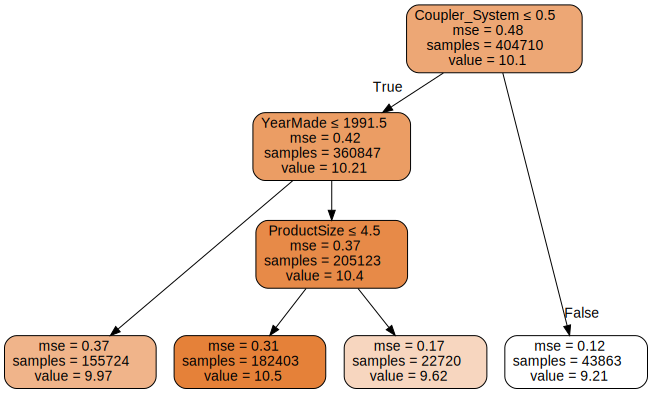

In [31]:
#Draw the model:
draw_tree(m, xs, size=10, leaves_parallel=True, precision=2)

Yukarıdaki plot'u anlamak, decision trees'i anlamanın en iyi yollarından birisi. Bu yüzden adım adım yukarıdaki grafiği açıklayacağız.

En üstteki node **initial model**'i temsil eder, yani herhangi bir split yapılmadan önceki durumu, yani tüm datanın tek bir grup olduğu durumu temsil eder. 

Bu model olabilecek en basit modeldir, gelen yeni dataya hiçbir soru sorulmadan, doğrudan bir prediction yapılır, bu prediction'da tüm dataset'in price average'ıdır. Yani tüm dataset'in average price'ı fixed prediction olarak set edilir. 

Bu durumda görüyoruz ki, modelin prediction value'su 10.1 olarak belirlenmiş, elbette hatırlarsan bu değer price'ın logaritması alınmış haliydi. En yukarıda y column'unun logaritması alınmıştı ki mse değeri bize kaggle'ın istediği logarithmic mse ile aynı skalada sonuç versin.

Yine ilk modele bakmaya devam ediyoruz, bu modelin **mse** değeri 0.48 olarak bulunmuş, bunun karekökünü alırsak **me** veya **rmse** değerinin 0.69 olduğu anlamına gelir. Unutma `m_rmse` yani **root mean squared error** değil de `mse`'den bahsediyorsak demek ki kök alınmamış halinden bahsediyoruz, yani average of square of the differences söz konusu. Şunu da tekrar belirtelim buradaki 0.69 mean error logaritması alınmış halinin mean error'u oluyor!

Yine ilk node'a yani ilk modele bakmaya devam ediyoruz, 404710 samples yani auction records bulunmuş. Bu grupta kaç tane datapoint olduğunu gösteriyor, şuan tüm veri tek grupta olduğu için, bu sayı training set'in size'ı olmuş olur.

İlk modelle ilgili son bilgi ise coupler_system <= 0.5 bilgisi. Bu bilgi şunu temsil eder the `decision criterion for the best split that was found`, Yani sanıyorum bu node için yani bu grup için en iyi ayrım coupler_system column'unun 0.5 değerini split point olarak kullanınca elde ediliyormuş. Tüm column'lar için farklı split points denendi ve ayrım sonucunda iki grup genelinde en az hata ile tahmin sağlayan split point bu olarak belirlendi.

Şimdi sol aşağıya doğru ilerleyerek bir başka node'a geçiyoruz, bu node 360847 samples'dan oluşan bir grubu temsil ediyor, bu grup `coupler_system` column'unun <= 0.5 olduğu datapoints'ten oluşuyor. Bu grup için dependent variable'ın average'ı 10.21 olarak bulunmuş.  

Initial Node'dan sola değil de sağa doğru inersek, coupler_system feature'ı > 0.5 olan datapoints'in gruplandığı bir node göreceğiz. Burada da 44k civarı datapoint yer alıyor ve ortalama sale price değeri 9.21 olarak belirlenmiş.

En altta kalan row, **leaf nodes** olarak isimlendirilir, bunlar nihai gruplarımızdır, bu gruplardan tekrar soru sorularak dallanma söz konusu değildir, yeni gelen data bu gruplardan birine dahil edilmeye çalışılacaktır.

Farkındaysan ilk gruba sorulan tek soru `is coupler_system <= 0.5` sorusu, sadece bu soru dahi datayı sale price'a göre anlamlı bir şekilde ikiye bölmeyi başarmış, bu feature'ı >0.5 olan parçalar bariz şekilde daha ucuza satılmış (10.21 yerine 9.21).

Soldaki node'a bir başka soru sorularak tekrar gruplama yapılmış en anlamlı gruplamayı sağlayacak bu soru da YearMade<=1991.5 olarak bulunmuş, bunu algoritma deneme yanılma ile buluyor. 

En sol alttaki node, yani grup, iki sorunun cevabına göre oluştu yani coupler_system<=0.5 ve YearMade<=1991 olan tüm datapoints bu gruba dahil oldu ve bu gruba yaklaşık 160k data dahil olduğu average value ise 9.97. 

Yine görüyoruz ki decision tree algoritması ilgili soru ile bariz şekilde pahalı auction record ile ucuz auction record'u ayırabildi.

Yukarıda elde ettiğimiz decision tree grafiğinin bir başka verisyonunu, dtreeviz library'si ile aşağıdaki gibi elde edebiliriz:

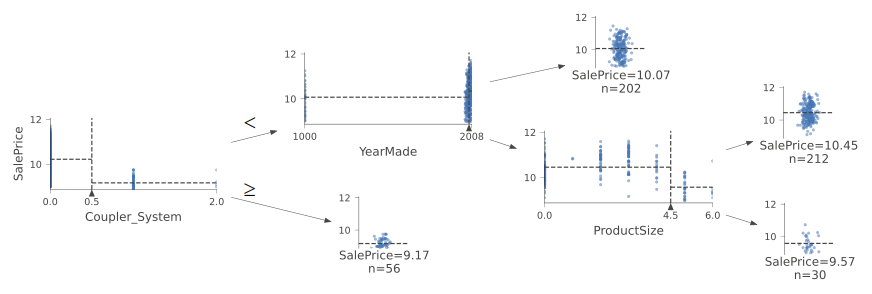

In [32]:
samp_idx = np.random.permutation(len(y))[:500]
dtreeviz(m, xs.iloc[samp_idx], y.iloc[samp_idx], xs.columns, dep_var,
        fontname='DejaVu Sans', scale=1.6, label_fontsize=10,
        orientation='LR')

Yukarıdaki chart her split point için data distribution'ı gösterir. Yukarıdaki grafikte görüyoruz ki YearMade ayrımında bir problem söz konusu, 1000 yılında yapılmış vazı bulldozers görünüyor. Presumably this is actually just a missing value code (a value that doesn't otherwise appear in the data and that is used as a placeholder in cases where a value is missing). For modeling purposes, 1000 is fine, but as you can see this outlier makes visualization the values we are interested in more difficult. So, let's replace it with 1950:

In [33]:
#Bu kod ile yapmak istediğimiz sanıyorum YearMade<1900 olan tüm datapoints'in YearMade'ini 1950 olarak değiştirmek.
#Böylece amacımız yukarıdaki charttaki problemi gidermek, YearMade ayrımını daha iyi görebilmek.
xs.loc[xs['YearMade']<1900, 'YearMade'] = 1950
valid_xs.loc[valid_xs['YearMade']<1900, 'YearMade'] = 1950

Bu değişiklikle birlikte tree visualization'ı tekrar yapalım, bu değişiklik model result'ında önemli bir değişiklik yapmamış olsa da gördüğün gibi chart'ı bariz şekilde iyileştirdi.

Bu örnekle şunu görmüş olduk ki decision tree algoritması data issues'a oldukça dirençli!

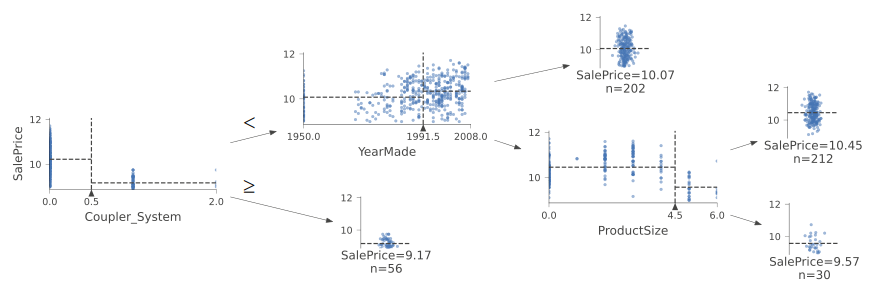

In [34]:
m = DecisionTreeRegressor(max_leaf_nodes=4).fit(xs, y)

dtreeviz(m, xs.iloc[samp_idx], y.iloc[samp_idx], xs.columns, dep_var,
        fontname='DejaVu Sans', scale=1.6, label_fontsize=10,
        orientation='LR')

Hatırlarsan yukarıdaki decision tree regressor modelini eğitirken bir stopping condition belirtmiştik: `max_leaf_nodes`= 4 şeklinde yani modele dedik ki, en fazla 4 leaf olsun, yani nihai olarak modeli 4 farklı gruba ayır! Bu yüzden görece küçük bir model elde ettik.

Şimdi hiçbir stopping criteria olmadan bir başka model eğitelim:

In [35]:
#Durma kriteri belirlenmeden yeni bir model eğitiliyor:
m = DecisionTreeRegressor()
m.fit(xs, y);

Competition root mean squared error (`m_rmse`) tipinde hata ölçtüğü için biz de kendi m_rmse fonksiyonumuzu aşağıda yaratıyoruz:

In [36]:
#Bu argüman olarak prediction'ı ve target'ı alıp me hesaplar:
def r_mse(pred,y): return round(math.sqrt(((pred-y)**2).mean()), 6)

#Bu ise aynı işlemi içine aldığı DecisionTreeRegrossor modelini kullanarak yapar:
def m_rmse(m, xs, y): return r_mse(m.predict(xs), y)

In [37]:
#İlgili decision tree modelinin training set için hatasına bakalım:
m_rmse(m, xs, y)

0.0

Hata 0.0 çıktı, yani training setteki her bir örnek için, doğru sale price değeri tahmin edilmiş, bu çok iyi görünüyor değil mi?

O kadar hızlı sevinme, kendi başına training set result'ı çok bir şey ifade etmez, gel bir de validation set'in error'una bakalım.

In [38]:
m_rmse(m, valid_xs, valid_y)

0.331466

Görüyoruz ki burada bir overfitting söz konusu, peki neden böyle oldu? Modelin kaç leaves içerdiğine bir bakalım:

In [39]:
m.get_n_leaves(), len(xs)

(324544, 404710)

Totalde 400k data için 330k leaves söz konusu yani neredeyse her bir datapoint için ayrı bir grup oluşturulmuş, bu modelin overfit etmesi gayet normal.

Sklearn'ın default settings'ini kullanırsak, her leaf node içinde tek bir item kalana kadar gruplamaya devam eder.

Generalization kabiliyeti daha iyi olacak bir model için aşağıdaki gibi bir sınır koyalım, bu kez max_leaf_nodes üzerinden sınır koymuyoruz da min_samples_leaf yani leaf node'lardaki minimum auction record üzerinden bir sınır koyuyoruz.

Artık biliyoruz ki bu model ile oluşturulan yaprak node'larında en az 25 data point olacak!

In [40]:
m = DecisionTreeRegressor(min_samples_leaf=25)
m.fit(to.train.xs, to.train.y)
m_rmse(m, xs, y), m_rmse(m, valid_xs, valid_y)

(0.248562, 0.323396)

Gördüğümüz gibi bu model daha iyi bir generalization sağlıyor. Totalde kaç tane leaves olduğuna bakalım:

In [41]:
m.get_n_leaves()

12397

Gayet güzel, 400k sample için 12k grup söz konusu, yani bir yaprak grupta ortalama 30 civarı data point var.

Sonuç olarak görüyoruz ki decision tree modeli gayet iyi çalışıyor. Variables arası nonlinear ilişkileri de yakalayabiliyor. 

Ancak görüyoruz görece küçük modeller bize daha iyi bir generalization sağlarken, training set performansı ise kötü oluyor. Buna karşın görece büyük modeller ise training sette daha iyi performans sağlarken, daha kötü generalize ediyor.

Peki bu trade-off'u gözeterek doğru tree boyutunu nasıl bulacağız? Bu sorunun cevabını biraz sonra vereceğiz ancak ondan önce, Categorical Variables'ı nasıl handle edebileceğimize bakalım.

### Categorical Variables

Önceki chapter'da, deep learning networks ile uğraşırken, categorical variables ile başetmek için variable'ın one-hot encoding vektörünü embedding layer'a beslemiştik. Böylece discrete categorical variables'ı, continious ve anlamlı variables'a çevirmiştik, bunun detaylarını zaten konuştuk. Embedding layers fikrinin ne kadar etkili ve büyüleyici olduğundan bahsettik.

Yukarıda yaptığımız decision tree algoritmasında ise embedding layers kullanılmadı, one-hot encoding bile kullanılmadı, sadece her bir categorical variable'ın farklı levelları için sorular oluşturuldu ve bu sorular eğer datayı mantıklı şekilde ayırabiliyorsa, split point olarak seçildi.

Örneğin **product code** gibi hiçbir şey ifade etmeyen ve hiçbir processing'e maruz kalmamış bir categorical column nasıl oluyor da decision tree için anlamlı şekilde kullanılabiliyor? Kullanılıyor işte! Diyelim ki spesifik bir kod'a sahip olan ürünler bariz daha pahalı oluyor, o halde model bu kod'u bir split point olarak seçiyor, bunu yaparak ayırdığı gruplar minimum error ile çalışabildiği için böyle yapıyor.

In a decision tree, we don't have embeddings layers—so how can these untreated categorical variables do anything useful in a decision tree? For instance, how could something like a product code be used?

Aslında istersek categorical bir column'u one-hot encoding kullanarak birden fazla categorical variable ile değiştirebiliriz, bunun için Pandas'ın `get_dummies` methodu kullanılabilir.

Ancak şunu belirtmek gerek ki bu yaklaşımın diğerine kıyasla sonuca herhangi bariz bir olumlu katkısı yoktur. Bu yüzden bu yaklaşımı kullanmayız çünkü dataset'i daha complex hale getirmekten başka bir işe yaramaz.

It is also possible to use one-hot encoding to replace a single categorical variable with multiple one-hot-encoded columns, where each column represents a possible level of the variable. Pandas has a `get_dummies` method which does just that.



> : The standard approach for nominal predictors is to consider all $2^{k-1} − 1$ 2-partitions of the *k* predictor categories. However, this exponential relationship produces a large number of potential splits to be evaluated, increasing computational complexity and restricting the possible number of categories in most implementations. For binary classification and regression, it was shown that ordering the predictor categories in each split leads to exactly the same splits as the standard approach. This reduces computational complexity because only *k* − 1 splits have to be considered for a nominal predictor with *k* categories.

Şimdi decision trees'in nasıl çalıştığını kavradığımıza göre, it's time for the best-of-both-worlds solution: random forests.

## Random Forests

1994'te Berkeley professsor Leo Breiman, küçük bir teknik rapor yayımlad: ["Bagging Predictors"](https://www.stat.berkeley.edu/~breiman/bagging.pdf). Daha sonra bu rapor modern machine learning için en önemli en influential fikirlerden biri oldu.

Rapor şöyle başlıyordu:

> : Bagging predictors is a method for generating multiple versions of a predictor and using these to get an aggregated predictor. The aggregation averages over the versions... The multiple versions are formed by making bootstrap replicates of the learning set and using these as new learning sets. Tests… show that bagging can give substantial gains in accuracy. The vital element is the instability of the prediction method. If perturbing the learning set can cause significant changes in the predictor constructed, then bagging can improve accuracy.

Breiman'ın önerdiği prcedure şöyleydi:

1. Data içerisinden random olarak bir subset seç. ("bootstrap replicates of your learning set")
1. Bu subset'i kullanarak bir model train et.
1. Bu modeli kaydet ve bir kaç kez ilk adıma geri dön.
1. Sonuç olarak elimizde her biri datamızın subsetleri ile eğitilmiş birden fazla model olacak. Yeni bir prediction yaparken, tüm modelleri kullan ve tüm modellerin prediction average'ını overall prediction olarak kullan.

Bu procedure'a **"bagging"** denir. Bu yöntemin dayandığı insight şu: tüm dataset üzerinde tek bir model eğitmek yerine, subsets üzerinde ayrı ayrı modeller eğitiyoruz, belki bu subsets models tüm dataset'i gözettiğimizde tek modele göre daha çok hata yapacak ama, önemli nokta şu bu modellerin hataları correlated olmayacak, different models make different error! Therefore the average of those errors is zero!

Model sayımız arttıkça, average işlemi bizi correct answer'a daha da yaklaştırır. Bu çok önemli bir fikir, bu yöntemle neredeyse tüm çeşit ML algoritmalarının accuracy'sini artırabiliriz. Yapmamız gereken şey basitçe, farklı modelleri training set'in susbsets'i üzerinde train etmek ve daha sonra predictions'ın average'ını almaktan ibaret.

2001'de Leo Breiman bu fikri pratik olarak decision tree üzerinde denedi. Hatta her modelin eğitimi için random rows'ları seçerek bir subset oluşturmanın bir adım ötesine geçti, her bir tree için split point'i belirlemek için random bazı columns seçti, yani anladığım kadarıyla modeli bu randomly seçilen column'ları baz alarak split points belirlemesi için zorladı. Bu methoda da **Random Forest** ismini verdi. Şuanda bu method pratikte en çok kullanılan ML methodlarından birisi.

Özünde, random forest çok sayıda decision tree modelinin predictions average'ını alan bir ortak akıl gibi çalışıyor. Her bir tree randomly selected farklı parametrelerle ve farklı subset'ler üzerinde eğitiliyor böylece ortak akılın gücü devreye giriyor. Modeller kendi başına hatalı da olsa, average alındığı zaman gerçek sonuca oldukça yaklaşılıyor.

Burada yapılan **bagging** procedure'u bir çeşit **ensembling** yöntemidir, yani birden fazla modelin sonuçlarını combine etme durumu.

Şimdi random forest algoritmasına pratikte bakalım:

### Creating a Random Forest

Bir random forest modelini decision tree gibi yaratabiliriz, ancak bu kez bazı ekstra parametreler belirtmemiz gerek: örneğin how many trees should be in the forest, how we should subset the data items(the rows), and how we should subset the fields(columns).

Aşağıdaki fonkisyon tanımında, 

    - n_estimators: the number of trees we want.
    - max_samples: defines how many rows to sample for training each tree.
    - max_features: defines how many columns to sample at each split point (where `0.5` means "take half the total number of columns").
    - min_samples_leaf: geçen sefer kullandığımız tree parametresi, dallanmanın ne zaman duracağına dair bir koşul, yapraklarda bulunabilecek minimum sample sayısını veriyoruz.
    - n_jobs=-1: to tell sklearn to use all our CPUs to build the trees in parallel.

Bu parametrelerin farklı varyasyonlarıyla farklı random forest modelleri eğitebilmek için, aşağıdaki gibi bir function oluşturuyoruz, böylece bu tek satırda random forest modeli yaratıp eğitmiş oluyoruz.

In [42]:
def rf(xs, y, n_estimators=40, max_samples=200_000, max_features=0.5, min_samples_leaf=5, **kwargs):
    return RandomForestRegressor(n_jobs=-1, n_estimators=n_estimators, max_samples=max_samples, max_features=max_features,
        min_samples_leaf=min_samples_leaf, oob_score=True).fit(xs, y)

In [43]:
m = rf(xs, y);

Random Forest modelimizin sonucuna bakarsak(RMSE hata performansı), geçen başlıktaki `DecisionTreeRegressor` modelinden bariz bir şekilde daha iyi performans sergilediğini görürüz, 0.3'lerden 0.23'lere kadar düşmüş.

In [44]:
m_rmse(m, xs, y), m_rmse(m, valid_xs, valid_y)

(0.170917, 0.233975)

Random forests'ın en önemli özelliklerinden birisi ise şudur: `they aren't very sensitive to the hyperparameter choices`. 

Doğal olarak `n_estimators` sayısını arttırdıkça daha fazla tree yaratacağımız için, modelimizin accuracy'i artacaktır ancak bunun yanında eğitim süresi de artacaktır. 

Genelde `max_samples` parametresine dokunmayız, model yaratılırken default değer kullanılır, ancak yukarıda olduğu gibi eğer elimizdeki dataset 200k data points'den fazlasına sahipse bu değeri 200k'ya set etmek hem accuracy'i çok az etkileyerek training süresini hızlandıracaktır.

`max_features=0.5` and `min_samples_leaf=4` both tend to work well, although sklearn's defaults work well too.

Sklearn dökümantasyonu farklı max_features seçimlerinin artan tree sayısı için sonuca etkisini göstermiş: [show an example](http://scikit-learn.org/stable/auto_examples/ensemble/plot_ensemble_oob.html)

Aynı plot aşağıda da var. Burada mavi line, en az sayıda feature'ı kullanırken, yeşil line ise en fazla sayıda feature (hepsini) kullanıyor. Grafikten gördüğümüz üzere, en iyi sonucu çok sayıda tree için subset of features(columns) kullanarak alıyoruz. .

<img alt="sklearn max_features chart" width="500" caption="Error based on max features and number of trees (source: https://scikit-learn.org/stable/auto_examples/ensemble/plot_ensemble_oob.html)" src="../images/sklearn_features.png" id="max_features"/>

Şimdi tree sayısının seçiminin, yani `n_estimators` parametresinin etkisini görelim. `estimators_` attribute'unu kullanarak, forest modelimizin içindeki ayrı ayrı tree'lerin prediction'larına ulaşabiliriz. Hatırlarsan bizim forest modelimiz 40 tree ile eğitilmişti.

Aşağıdaki satırda yapılan işlem şu: estimators_ attribute'u içerisinden tek tek tree modelleri alınıyor, ardından her tree modeline validation set beslenerek tahminler alınıyor yani validation sette 7k data varsa 7k prediction alınıyor daha sonra, diğer modelin 7k tahmini de bunun yanına stack ediliyor sonuçta preds 2D bir array olacak 7k x 40 yani her bir tree için 7k tahmin söz konusu.

Bu tahminlerin ortalamasını alırsam, zaten forest'ın yaptığı şeyi yapmış olurum. O halde forest ile aynı sonucu elde etmem gerekir.

In [45]:
#Ayrı ayrı tree modellerinin prediction'larını buluyorum: 7kx40 
preds = np.stack([t.predict(valid_xs) for t in m.estimators_])

Şimdi `preds.mean(0)` dersem random forest ile aynı predictions'ı elde etmeliyim:

In [46]:
r_mse(preds.mean(0), valid_y)

0.233975

Şimdi aşağıda şunu yapacağız, tek bir tree kullanarak alınan validation sonucundan başlayarak, sırasıyla tree sayısı arttıkça nasıl sonuçlar elde ediyoruz onu göreceğiz.

Görüyoruz ki RMSE değeri tree sayısı arttıkça düşüyor. Buna karşın 30 tree'den sonra artış hızı gittikçe düşüyor.

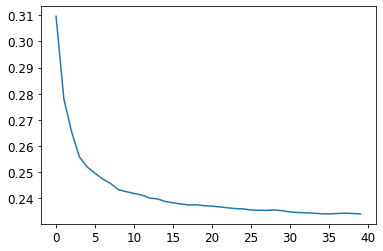

In [47]:
plt.plot([r_mse(preds[:i+1].mean(0), valid_y) for i in range(40)]);

Hatırlarsan, random forest modelimizin training performansı 0.17 civarı iken validation performansı 0.23 civarı idi. Peki bunun sebebi ne? Modelimizin overfit ediyor olması mı yoksa, validation set başka bir time-period'da olduğu için doğal olarak tahmin etmesi daha mı zor oluyor. Yoksa iki faktör de biraz etkili mi?

Şuana kadarki bilgilerimizle bu sorunun cevabını veremiyoruz, ancak Random Forests için zekice bir trick var **out-of-bag** (OOB) error dediğimiz parametre bize yukarıdaki sorunun cevabını verebilir.

### Out-of-Bag Error

Hatırlarsan random forest içindeki her tree modeli ayrı bir subset data üzerinde eğitilmişti. OOB error ile sadece training set'i kullanarak prediction error'u ölçebiliyoruz. Anladığım kadarıyla OOB error hesaplanırken her bir tree'nin eğitilirken kullanmadığı row'lar üzerindeki hatası dikkate alınıyor. Böylece ayrı bir validation set'e ihtiyacımız olmadan modelin overfit edip etmediğini anlayabiliyoruz.

Bu OOB error'u şöyle ölçüyoruz, diyelim ki 400k datapoint'imiz var m.oob_prediction_ dediğimizde 400k prediction elde ediyoruz. Ancak bu predictions için tüm trees kullanılmıyor, yani örneğin ilk data point'in prediction'ını sadece, bu datayı daha önce görmemiş trees'i kullanarak hesaplıyoruz, böylece aslında modele daha önce görmediği bir data vermiş gibi oluyoruz. Bu yüzden bu prediction'ları training targets (y) ile kıyasladığımızda, elde edilen hata bir nevi validation set hatası gibi oluyor. Bu hataya bakarak, modelin trainining datasına overfit edip etmediğini, yine training datasını kullanarak elde edebiliyoruz. Çünkü aslında model eğitimde training datasının tamamını kullanmadı.

> A: My intuition for this is that, since every tree was trained with a different randomly selected subset of rows, out-of-bag error is a little like imagining that every tree therefore also has its own validation set. That validation set is simply the rows that were not selected for that tree's training.

Bu yöntem özellikle az training data'mız olduğunda yararlı oluyor, çünkü training set'i bölüp validation set elde etmeye gerek kalmadan, modelimizin ne kadar iyi generalize edebildiğini görebilmiş oluyoruz. 

Bana kalırsa burada hala bir problem var gibi görünüyor, tamam belki her tree'ye daha önce görmediği data'yı veriyoruz ama bu data random seçiliyordu, yani time-series datası arasından random ayrım yapılıyor, o yüzden burada tree'lerin henüz görmediği data tam olarak görmediği data değil, bence bu hata ile time-series datası için doğru bir validation estimation'ı alamayız!

OOB predictions'ı ulaşmak için `oob_prediction_` attributune'unu kullanırız. 

Unutma hata hesaplarken, training set'in target'lerini yani y'yi kullanarak karşılaştırma yapıyoruz, çünkü oob prediction training set datapoint'lerini input olarak modele veriyor.

In [48]:
r_mse(m.oob_prediction_, y)

0.210681

Görüyoruz ki OOB error'umuz validation set error'undan bariz şekilde daha düşük (0.23 yerine 0.21). This means that something else is causing that error, in *addition* to normal generalization error. We'll discuss the reasons for this later in this chapter.

Yukarıdaki yöntem model's predictions'ı interpret etmenin tek bir yolu, aşağıda daha başka interpretation yollarına bakalım:

## Model Interpretation

Tabular data için model interpretation özellikle önemlidir. Bir tabular model için aşağıdaki soruların cevapları ile ilgileniriz:

- How confident are we in our predictions using a particular row of data?
- For predicting with a particular row of data, what were the most important factors, and how did they influence that prediction?
- Which columns are the strongest predictors, which can we ignore?
- Which columns are effectively redundant with each other, for purposes of prediction?
- How do predictions vary, as we vary these columns?

Göreceğiz ki random forests modeli bu soruları cevaplamak için gayet uygun bir model. İlk soru ile başlayalım:

### Tree Variance for Prediction Confidence

Biliyoruz ki random forest modelimiz, bir data point için tahmin oluştururken tüm tree'lerin o data point için yaptığı tahminin ortalmasını alır.

Peki herhangi bir row (data point) için yapılan estimate'ın confidence'ını nasıl bilebiliriz? Yani bir data point için yapılan tahminden acaba modelimiz ne kadar emin? 

Bunu anlamanın basit bir yolu, standard deviation'a bakmak, yani şöyle elimizde 40 tree'lik bir forest varsa, x data point'i için 40 adet farklı prediction yapılmış olacak, bu datapoint'lerin mean etrafında nasıl dağıldığının bir göstergesi standard deviation'dır. This tells us the *relative* confidence of predictions. Eğer bir row için tree'ler mean etrafında çok büyük bir range'de tahminler yapmışlarsa (higher standard deviations) demek ki bu row için yapılan tahminden çok da emin olmamamız gerek çünkü tree'lerin fikir birliği yok, her kafadan ayrı bir ses çıkıyor. Buna karşın eğer bir data point için lower standard deviations söz konusuysa demek ki tree'ler yakın sonuçlar veriyor, ve fikir birliği sağlanmış bu row'un relative confidence'ı daha yüksektir diyebiliriz.

Şimdi list comprehension kullanarak, forest modeli (m) içerisindeki her estimator için validation set predcition'ını bulalım ve bunları stackleyelim:

In [49]:
preds = np.stack([t.predict(valid_xs) for t in m.estimators_])

In [50]:
preds.shape

(40, 7988)

Validation setimiz içerisinde 8k data point olduğu için sonuçta preds içerisinde yukarıda görüldüğü gibi her 40 tree için de 8k tahmin verisi tutuluyor.

Yani her tree'nin validation setteki her auction için (40 trees and 7,988 auctions) prediction'ı elimizde.

Bu veriyi kullanarak, her bir auction yani her bir row için tree'lerin tahminlerinin standard deviation'ını yani bu tahminlerin mean'den ne kadar saptığını bulabiliriz. (her row için 40 tahminin mean değerlerinden ne kadar saptığının ölçüsü)


In [51]:
preds_std = preds.std(0)
preds_std.shape

(7988,)

Yukarıda gördüğümüz üzere artık validation setteki her row için elimizde standard deviations var. Bunlar her row için modelimizin relative confidence'ının bir ölçüsü.

Örneğin ilk beş row için standar deviations'a bakalım:

In [52]:
preds_std[:5]

array([0.25065395, 0.11043862, 0.08242067, 0.26988508, 0.15730173])

Göründüğü üzere, prediction confidence'ı değişkenlik gösteriyor. Örneğin ikinci auction için standard deviation küçük demek ki bu satır için tree'ler fikir birliği sağlamış, mean etrafında küçük oynamalar söz konusu. Buna karşın ilk auction için, tree'ler fikir birliği sağlayamamış, tahminden tam emin değiller.

Diyelim ki biz bu modelin sonuçlarını baz alarak bir auction'da bir item'ı almayı düşünüyoruz. Modele item verilerini verince model bizde dedi ki bu item 10k dollars eder, ancak sonra relative confidence'a baktık, çok düşük, bazı tree'ler demiş ki 5 dollars ancak eder, kimisi demiş 100k dollars eder. O halde bu ürün için modelin tahminine çok da güvenmemek gerek, model bu row için low-confidence bir prediction yapmış.

Buna karşın, eğer tree'lerin hepsi bir ürünün 10k dollars edeceğinden eminse o ürün için standard deviation değeri görece düşük çıkacaktır, o halde sonuca daha çok güvenebiliriz. Relative confidence is higher.

### Feature Importance

İlk soruyu cevapladık yani modelin bir row sonucunu verirken ne kadar emin olduğunu nasıl anlayacağımızı kavradık. Şimdi ikinci soruya bakıyoruz, buradaki soru da şu: bir row'un sonucunu tahmin ederken, en önemli feature'lar hangileri oldu, hangi feature'lar prediction result'u nasıl etkiledi?

Yani elimizde accurate predictions yapan bir model olması ile yetinmiyoruz, bu modelin bu predcitions'ı nasıl yaptığını da anlamak istiyoruz. **Feature Importance** bize bu konuda bir insight verir. 

Feature importance'ı doğrudan sklearn random forest modelimizin `feature_importances_` attribute'una bakarak görebiliriz. 

Here's a simple function we can use to pop them into a DataFrame and sort them:

In [53]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

Yukarıda yaratılan fonksiyona, forest modeli ve training set veriliyor sonuçta, modelin tahmin yaparken kullandığı en önemli feature'lar belirleniyor. Aşağıda görüldüğü gibi `YearMade` ve `ProductSize` gibi feature'lar listenin en üstünde yer alıyor, yani prediction'ı en çok etkileyen feature'lar bunlarmış. Zaten intuitive olarak düşününce de bu feature'ların önemi anlaşılıyor.

Burada tüm feature importance değerlerinin toplamının 1 değerine eşit olduğuna dikkat et!

In [54]:
fi = rf_feat_importance(m, xs)
fi[:10]

,cols,imp
59,YearMade,0.180070
7,ProductSize,0.113915
31,Coupler_System,0.104699
8,fiProductClassDesc,0.064118
33,Hydraulics_Flow,0.059110
56,ModelID,0.059087
51,saleElapsed,0.051231
4,fiSecondaryDesc,0.041778
32,Grouser_Tracks,0.037560
2,fiModelDesc,0.030933


Aşağıdaki plot, feature'ların relative importance'ını daha bariz gösteriyor.

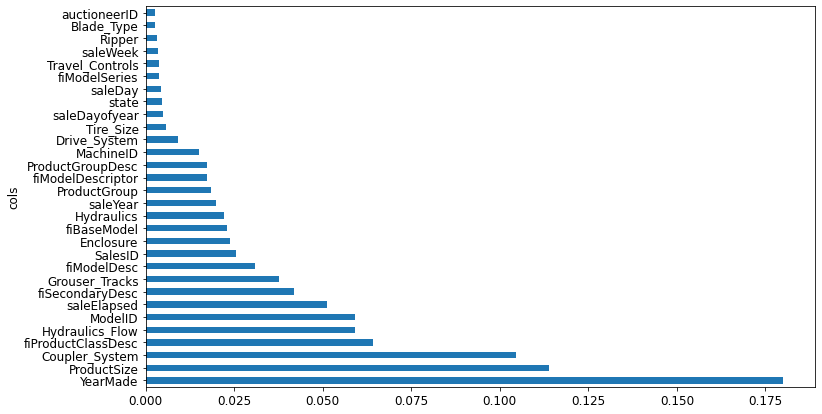

In [55]:
def plot_fi(fi):
    return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

plot_fi(fi[:30]);

Bu importance değerlerinin hesaplama yönteme kolay ama şık. Feature importance algoritması, her tree'yi looplayarak, her tree içindeki branch'lere recursive olarak keşfediyor. 

Her tree'nin her bir dallanması için, ilgili dallanmada hangi feature'ın split point olarak kullanıldığına, ve bu split sonrasında modelin ne kadar improve ettiğine bakıyor. The improvement (weighted by the number of rows in that group) is added to the importance score for that feature.

This is summed across all branches of all trees, and finally the scores are normalized such that they add to 1.


Yani benim anladığım şöyle bir şey yapılıyor, her tree'nin her grubu boyunca geziliyor, o grubun split point'i için hangi feature kullanıldığına bakılıyor buna göre ilgili feature'a bir score ekleniyor. Örneğin ilk grupta 1000 sample var, mse değeri 0.9, bu grup A feature'ı ile iki gruba ayrılmış bir grupta 300 sample var hata değeri 0.6 diğer grupta ise 700 sample var hata değeri 0.4, o halde mesela  A feature'ının importance'ı artacak kabaca 300*(0.9-0.6) + 700*(0.9-0.4) gibi bir değeri A'nın importance'ına ekleyeceğiz, yani böldüğü grupların boyutu ile hata improvement'larının çarpımları.

Böyle tüm forest gezildiğinde en çok hangi feature'ların kullanıldığını, performansa olan etkilerini de gözeterek hesaplamış olacağız!

### Removing Low-Importance Variables

Yukarıdaki feature importance analizi bizi şu sonuca götürüyor. Madem forest modeli için, sadece belli başlı feature'lar önem arzediyor (split point olarak kullanılıp, sonrasında iyi performans artışı sağlanıyor). O halde diğer feature'ları tutmaya gerçekten gerek var mı? 

Bence yok. Zaten tutsak da tutmasak da forest modelimiz sadece belli feature'ları kullanıyor.

O halde feature importance'ı 0.005'ten küçük olan feature'lardan yani columns'dan kurtulalım, ve sadece kalan column'larla bir model eğitelim bakalım sonuç ne olacak.

In [56]:
#Kaç tane column'un importance değerinin 0.005'den büyük olduğuna bakalım:
to_keep = fi[fi.imp>0.005].cols
len(to_keep)

21

Totalde 65 column'luk dataset yerine 20 column'luk dataset kullanabilirim kalan 44 column çok da bir işe yaramıyor.

Şimdi sadece yukarıdaki önemli 20 column'u kullanarak bir model eğitelim:

In [57]:
#Eski data sets'in sadece ilgili column'ları seçerek yeni datasets oluşturuyoruz.
xs_imp = xs[to_keep]
valid_xs_imp = valid_xs[to_keep]

In [58]:
#Şimdi ise yeni training set ile random forest modelimizi oluşturup eğitelim:
m = rf(xs_imp, y)

Yeni modelin performasına bakalım:

In [59]:
m_rmse(m, xs_imp, y), m_rmse(m, valid_xs_imp, valid_y)

(0.181204, 0.230329)

Çok daha küçük bir dataset ile çalışmamıza rağmen, accuracy değerimiz aşağı yukarı aynı kaldı! 65 yerine 20 column!

In [60]:
len(xs.columns), len(xs_imp.columns)

(66, 21)

Genelde bir modeli improve etmenin ilk adımı, modeli simplify etmektir. 66 column yerine 21 column kullanmak çok daha kolaydır, modeli interpret ve maintain etmem bariz şekilde kolaylaşır.

Feature importance plot'una tekrar bakarsak, daha temiz bir görüntü göreceğiz:

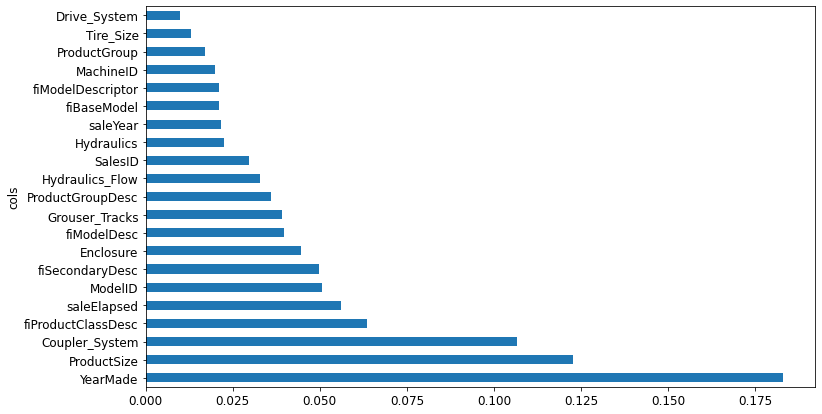

In [61]:
plot_fi(rf_feat_importance(m, xs_imp));

Low importance feature'lardan kurtulduk, fakat interpretation'ı zorlaştıran bir diğer etken şudur: bazı features, high importance görünmesine rağmen aslında bir başka feature ile çok yakın bir anlam taşıyor olabilir (prediction'a olan etkisi bazında) 

Yani iki feature aşağı yukarı aynı şeyi temsil ediyor olabilir, o halde bu feauture'ların yalnızca bir tanesini tutmak yeterli olacaktır.

Bu gereksiz feature'lara redundant features deriz, bir sonraki başlıkta bunlardan nasıl kurtuluruz ona bakalım:

### Removing Redundant Features

Bu kısımda redundant feature'ları nasıl bulup onlardan kurtulacağımıza bakalım, bir önceki başlıkta low importance features'dan kurtulup xs_imp training dataset'ini oluşturmuştuk, bunu kullanarak aşağıdaki chart'ı elde ediyoruz:

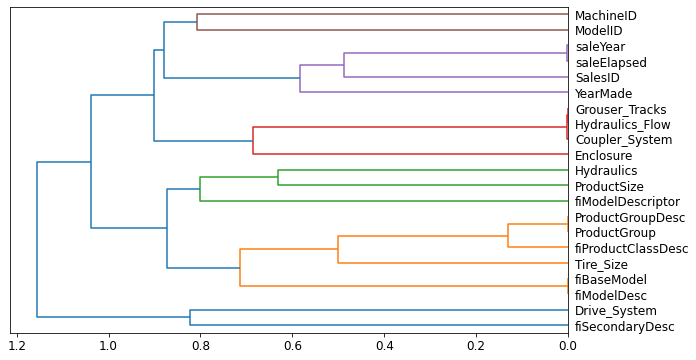

In [62]:
cluster_columns(xs_imp)

Bu grafikte erken merge eden column'lar most similar column'lar oluyor. Yani sağdan başlandığında erken birleşen column'lara bakarsak `ProductGroupDesc` ve `fiProductClassDesc`,  `saleYear` ve `saleElapsed`, `fiModelDesc` ve `fiBaseModel` gözümüze çarpar. Bu columns son derece erken merge eder, yani bu feature'lar linearly dependent features olarak düşünülebilir. Modelimizi daha da basitleştirmek için buradaki redundant feature'lardan kurtulmak isteriz.


> note: Determining Similarity: The most similar pairs are found by calculating the _rank correlation_, which means that all the values are replaced with their _rank_ (i.e., first, second, third, etc. within the column), and then the _correlation_ is calculated. (Feel free to skip over this minor detail though, since it's not going to come up again in the book!)

Şimdi bu closely related feature'lardan bazılarından kurtulmaya çalışalım bakalım accuracy'i etkilemeden modelimizi simplify edebilecek miyiz?

Aşağıda bir random forest yaratan train eden ve modelin OOB score'unu return eden bir fonksiyon tanımlanmış. Yaratılan yeni forest modelleri için lower `max_samples` and higher `min_samples_leaf` parametreleri kullanılıyor.

OOB Score aslında R2 score'una karşılık geliyor, detayı burada önemli değil, 0.0-1.0 arası bir score verecek. Eğer bu skor 1.0 ise model performansı harika demektir, yok eğer sonuç 0.0 ise model performansı random bir modelin performansına eşit demektir. Bir nevi random modelin performansını base olarak kabul eden bir performans kriteri.

Şuandaki amacımız çok kesin performans skorları elde etmek değil, amacımız bazı redundant column'ları sildikten sonra eğitilen yeni modelin performansını eskileri ile kıyaslayabilmek.

In [63]:
def get_oob(df):
    m = RandomForestRegressor(n_estimators=40, min_samples_leaf=15,
        max_samples=50000, max_features=0.5, n_jobs=-1, oob_score=True)
    m.fit(df, y)
    return m.oob_score_

Öncelikle baseline olarak, herhangi bir feauture kaldırmadan önce modelin OOB/R2 score'unu buluyoruz:

In [64]:
get_oob(xs_imp)

0.8768243241012634

Şimdi teker teker, modelimizden redundant feature'ları kaldırıyoruz, ve her bir feature removal için yeni bir model eğitip hızlıca OOB score'una bakıyoruz:

In [65]:
{c:get_oob(xs_imp.drop(c, axis=1)) for c in (
    'saleYear', 'saleElapsed', 'ProductGroup','fiProductClassDesc',
    'fiModelDesc', 'fiBaseModel',
    'Hydraulics_Flow','Grouser_Tracks', 'Coupler_System')}

{'saleYear': 0.8766429216799364,
 'saleElapsed': 0.8725120463477113,
 'ProductGroup': 0.8780099968519656,
 'fiProductClassDesc': 0.8741157446899059,
 'fiModelDesc': 0.8760365396140016,
 'fiBaseModel': 0.8769194097714894,
 'Hydraulics_Flow': 0.8775975083138958,
 'Grouser_Tracks': 0.8780246481379101,
 'Coupler_System': 0.8780158691125818}

Şimdi ise her pair'den birer tane olmak üzere birden fazla feature'ı tek seferde drop edeceğiz ve bu halde yeni bir model eğitip performansa bakacağız:

In [66]:
to_drop = ['saleYear', 'ProductGroup', 'fiBaseModel', 'Grouser_Tracks']
get_oob(xs_imp.drop(to_drop, axis=1))

0.8744483753486655

Sonuçta, bu redundant feature'ları kaldırınca model performansı beklendiği gibi neredeyse sabit kaldı. O halde bu feature'lara gerçekten ihtiyacımız yok, bu feature'ları kalıcı olarak dataframe'imden silebilirim. Böylece modelimizi daha da simplify etmiş olacağız.

Şimdi bu feature'ları dataframe'lerden kalıcı olarak drop edelim ve yeni training ve validation datasını final appendix'i ile .pkl dosyası olarak save edelim.

In [67]:
xs_final = xs_imp.drop(to_drop, axis=1)
valid_xs_final = valid_xs_imp.drop(to_drop, axis=1)

In [68]:
save_pickle(path/'xs_final.pkl', xs_final)
save_pickle(path/'valid_xs_final.pkl', valid_xs_final)

Daha sonra istersek bu dataframes'i geri yükleyebiliriz:

In [69]:
xs_final = load_pickle(path/'xs_final.pkl')
valid_xs_final = load_pickle(path/'valid_xs_final.pkl')

Confirmation amaçlı, son modelin RMSE değerine bakalım, yeni datasetimiz 66 column yerine 16 column kullanıyor çok daha basit bir model, bakalım performansı da aynı mı? Aynı kalmasını bekliyoruz:

In [70]:
m = rf(xs_final, y)
m_rmse(m, xs_final, y), m_rmse(m, valid_xs_final, valid_y)

(0.183446, 0.232421)

Gördüğümüz gibi performansta gözlü görülür bir değişim söz konusu değil. Sonuçta, önemsiz feature'ları remove ettikten sonra, redundant features'ı da remove ettik ve we've greatly simplified our model. 

Now, let's see how those variables affect our predictions using partial dependence plots.

### Partial Dependence

Gördüğümüz üzere, ProductSize ve YearMade feature'ları en gruplama için en önemli feature'lardan ikisi. Bu feature'lar ile sale price arasındaki ilişkiyi daha iyi anlamak istiyoruz. Anlamak istediğimiz şey, modelimizin nasıl bir ilişki kurduğu! Yani model kendi içerisinde, YearMade ile ProductSize'ı nasıl ilişkilendiriyor bunu anlamaya çalışıyoruz, bu yüzden validation set'i kullanıyoruz. Bu feature'lar değiştirilince model prediction'ı nasıl değişiyor acaba, bunu anlayarak partial dependence'i anlayacağız.

İlk olarak Pandas value_counts methodunu kullanarak, ProductSize feature'ı için kaç kategori olduğunu ve bu kategorilerin görülme sıklığına bakacağız:

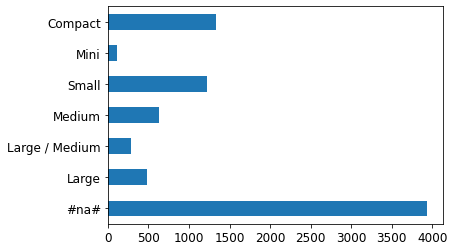

In [71]:
p = valid_xs_final['ProductSize'].value_counts(sort=False).plot.barh()
c = to.classes['ProductSize']
plt.yticks(range(len(c)), c);

En fazla görülen kategori `#na#` bu gerçek bir kategori değil, fastai ProductSize'ı missing olan kategorileri bu değerle dolduruyor.

Şimdi aynı işlemi `YearMade` için de yapalım. Bu feature numeric olduğu için, histogram gragiği kullanacağız, belirli discrete gruplar için görülme sıklıklarına bakacağız:

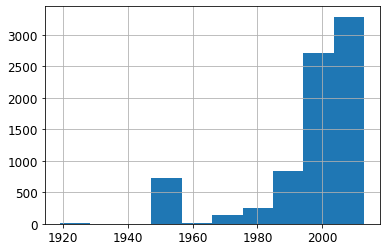

In [72]:
ax = valid_xs_final['YearMade'].hist()

Missing values'u replace etmek için 1000 değeri kullanılıyordu, biz bunu 1950'ye çekmiştik, bu değerleri saymazsak, data'nın çoğu 1990'dan sonra.

Şimdi **partial dependence plots** için hazırız. Bu plots ile cevap vermek istediğimiz soru şu: "Eğer bir row'un diğer tüm feature'ları aynı kalmak şartıyla, sadece ilgili feature'ını değiştirirsek, bu dependent variable'ı nasıl etkiler?"

Örneğin, diğer tüm feature'lar sabit kaldığı takdirde `YearMade` feature'ı sale price'ı nasıl etkiler?

Bunu yapmak için akla gelen bir yol şu olabilir: "Gidelim örneğin 1950 yılında yapılmış ürünler  (rows) için modelin sale price prediction'ının ortalamasını alalım, aynı işlemi farklı yıllar için yaptığımızda, şunu diyebilir miyiz: "Bak 1950 yılında yapılan ürünlerin ortalama fiyatı 10 dolar iken bu değer yıllar arttıkça artıyor, bu da bize partial dependence'ı gösteriyor."

Hayır yukarıdaki gibi bir mantık yürütemeyiz. Neden? Çünkü biz 1950 yılında yapılan rows'u aldığımız zaman, diğer column'lar sabit kalmış olmuyor, bu değişim ile fiyata olan etki sadece YearMade etkisi olmuyor, çünkü 1950 yılındaki ürünlerin örneğin AirCondioner gibi bazı başka feature'ları da bariz olarak farklı ve bunlar da fiyatı etkiliyor.

Bizim bulmak istediğimiz şey, yani partial dependence'dan kastımız ise sadece ve sadece YearMade feature'unun fiyata etkisi. İşte bunu bulabilmek için şöyle bir yaklaşım yapıyoruz. Tüm dataset üzerinde `YearMade` column'unu örneğin 1950 olarak değiştiriyoruz, model prediction'larını yapıyor. Bu sale price predictions'ının ortalamasını alıyoruz. Bu değeri 1950 ile ilişkilendirebiliriz!

Şimdi aynı işlemi yılı 1951 yaparak tekrarlıyoruz, and so forth until our final year of 2011. Böylece ne yapmış olduk, sadece ve sadece, YearMade column'u değişirse predictions bundan nasıl etkileniyor bunu görmüş olduk. İşte partial dependence dediğimiz şey de zaten budur.

Tekrarlıyorum, buradaki yaklaşımla, sadece istediğimiz feature'ın değiştiği hypotetical bir durumda sonucun nasıl değişeceğini görmüş oluyoruz, eğer biz direkt gidip 1950'de yapılan ürünlerin fiyat ortalamasını alsak buradaki değişimin tek sorumlusu yıl değildir, o yılın teknolojisine, ve daha birsürü şeye bağlı olarak fiyat değişecektir, yani fiyattaki değişimin sebebi bir çok feature olacaktır. Ancak bizim yaklaşımımızla yalnızca yıl column'unun etkisini görmüş oluyoruz, yani 1950'de klima olmamasına rağmen, eğer böyle bir şey olsaydı bile, ürün fiyatı yıldan nasıl etkilenecekti bunu görmüş oluyoruz.

Şimdi bu yaklaşımı gerçekleştirelim ve YearMade ve ProductSize için ortalama ürün fiyatlarının nasıl değiştiğini plot edelim bu da bize Partial Dependence'i verir:

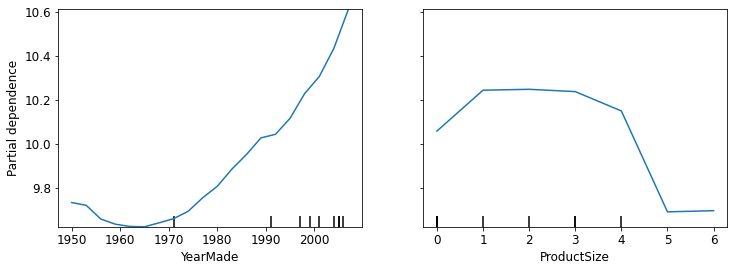

In [73]:
from sklearn.inspection import plot_partial_dependence

fig,ax = plt.subplots(figsize=(12, 4))
plot_partial_dependence(m, valid_xs_final, ['YearMade','ProductSize'],
                        grid_resolution=20, ax=ax);

`YearMade` plot'una bakarsak görüyoruzki burada neredeyse linear bir ilişki söz konusu. Unutma ki burada dependent variable'ımız logaritması alınmış halde, o halde gerçekte YearMade ile sale price arasında exponential bir ilişkiden söz edebiliriz. 

`ProductSize` plot'u ise biraz endişe verici. Burada missing values grubunun son grup, fiyatı görece düşük. Ancak neden bu kadar fazla missing values var ve bu ne anlama geliyor bunu anlamak isteriz. Bazı durumlarda missing values kullanışlı predictors olabilir, yani model bir feature'ın missing olup olmadığına dayanarak sağlıklı tahminler yapabilir, ancak bu durum tamamen, bu değerlerin neden missing olduğu ile alakalıdır. Bazı durumlarda ise missing values: **data leakage** işaretidir.


### Data Leakage

Data Leakage: Tahmin etmeye çalıştığımız target ile ilgili uygunsuzca kullanılan verilerin olması durumu. Yani normal şartlarda kullanılmaması gereken verilerin kullanılıyor olması durumu. Bunun en bariz örneği, target'ı tahmin etmek için target'in kendisinin input olarak kullanılması. Böyle modeller bizi şöyle çıkarımlara götürür: "It rains on rainy days", malumun ilanı.
Elbette pratikte bu uygunsuz veri kullanımı bilinçsizce olur ve anlaşılması güç olabilir.

Data leakage is subtle and can take many forms. In particular, missing values often represent data leakage.

Örneğin Jeremy bir kaggle competition'a katılmış, hangi projelerin grant alacağını tahmin eden bir model geliştiriyor, böylece amaç üniversitelerin kabul alma ihtimali yüksek proje başvurularına öncelik vermesi. Jeremy bu iş için bir random forest modeli kullanmış ve daha sonrasında feature importance ile hangi feature'ların gruplamalarda önem teşkil ettiğine bakmış. Şaşırtıcı sonuçlar bulmuş:

- Model 95% oranla doğru tahmin yapıyor.
- En önemli feature'lar meaningless identifier columns oluyor.
- Başvurunun haftanın ve yılın hangi günü yapıldığı en önemli feature'lar arasında yer alıyor. Örneğin Pazar günü yapılan başvuruların çoğu kabul ediliyor, bunun yanın January 1 tarihindeki başvuruların da çoğu kabul ediliyor.

Partial dependence plots'a bakarak söylüyoruz ki spesifik bir column missing olduğu zaman application neredeyse her zaman reject ediliyor. 

Bunlar garip duran sonuçlar ancak, pratikte olay şundan ibaret: Okul bu column'u yalnızca başvuru kabul edildikten sonra dolduruyormuş, kabul edilmeyen applications için ise genelde okul bu kısmı doldurmaya zahmet etmiyor. Yani burada modelimizde bir leakage söz konusu, model sonucu tahmin etmesi için kullanmaması gereken bir info kullanıyor. 

Aynı şekilde, kabul edilen projeler belirli bir tarihte toplu şekilde otomatik olarak process edildiği için, örneğin January 1 Pazar günü process edildiği için, model burada bir ilişki yakalıyor ancak aslında bunlar predictive veriler değil, yine burada bir leakage söz konusu.

Peki data leakage'ı identify etmek için ne yapacağız? Yukarıda gördüğümüz methodları kullanacağız. Öncelikle üzerine çok düşünmeden modelimizi build edeceğiz. Daha sonra:

- Model accuracy değerinin "too good to be true" olup olmadığına dikkat et.
- Important features'a bak, bunların gerçekte anlamlı olup olmadığına dikkat et, eğer anlamsız feature'lar karar verirken önem arz ediyorsa burada bir data leakage söz konusu olabilir.
- Partial dependence plots'a bak, gerçekte bu ilişkiler anlamlı mı bunu analiz et. Eğer bir information'ın missing olması bariz gruplandırmalara yol açıyor gibi görünüyorsa burada data leakage olabileceğinden şüphelen.

Yani daha önce deta cleaning için de söylediğimiz gibi, önce bir model build etmek bize daha iyi bir model build etmenin önünü açabiliriz, nasıl daha önce bu modeli kullanarak false labeled data'ları temizlediysek burada da benzer bir işlemle, training verisi içinde hileli bir veri karışmış olabilir mi bunu anlayabiliyoruz.

Genel olarak forest'ın kararlarına hangi faktörlerin etki ettiğini, bu faktörleri değiştirdiğimizde tree predictions'ın nasıl değiştiğini, spesifik örnekler için forest'ın tahmininden ne kadar emin olduğunu, hangi feature'ların reduntant ve hangilerinin dependent olduğunu analizlerle anlayabildik.

Son olarak tree interpreters ile, spesifik bir row için modelin tahmininde en önemli faktörleri anlamaya çalışacağız. Genel olarak hangi faktörlerin forest için önemli olduğunu zaten analiz etmiştik ama tek bir row için bu analizi nasıl yürüteceğiz?

### Tree Interpreter

In [74]:
#hide
import warnings
warnings.simplefilter('ignore', FutureWarning)

from treeinterpreter import treeinterpreter
from waterfall_chart import plot as waterfall

Bu section'ın başında belirttiğimiz gibi 5 soruya cevap arıyorduk:

- How confident are we in our predictions using a particular row of data?
- For predicting with a particular row of data, what were the most important factors, and how did they influence that prediction?
- Which columns are the strongest predictors?
- Which columns are effectively redundant with each other, for purposes of prediction?
- How do predictions vary, as we vary these columns?

Bu soruların dördüne zaten cevap verdik, sadece ikinci soru kaldı. Bu soruya cevap vermek için de `treeinterpreter` library kullanılacak. Bunun yanında `waterfallcharts` library kullanarak da sonucu chart olarak göreceğiz.

    !pip install treeinterpreter
    !pip install waterfallcharts

Tüm random forest modeli için feature importance'ı nasıl bulabileceğimize zaten bakmıştık. Temel fikir şuydu, forest'ın her tree'sinin her branch'ine bakıyoruz ve her split point için kullanılan feature'a ve bu feature ile yapılan ayrımın sonucu ne kadar iyileştirdiğine bakarak, cumulative biçimde o feature'ın importance'ını artırarak her feature için bir importance yüzdesine ulaşıyorduk.

Aynı işlemi tek bir row of data için de yapabiliriz. Diyelim ki auction'daki spesific bir item'a bakıyoruz. Modelimiz bu item'ın çok pahalıya satılacağını tahmin etmiş, biz de modelin neye dayanarak böyle bir tahmin yaptığını bilmek istiyoruz.

Bu amaçla ilgili row'u alırız, first decisioon tree'ye veririz, tree boyunca ilgili row of data final group'a ilerlerken hangi split point'lerden geçtiğine bakarız her splitten sonraki grup için tahmin sonucundaki artışı veya düşüşü hesaba katarak ilgili split variable'a bir importance atarız. Bu işlemi tüm tree'ler boyunca yapınca, ilgili row of data için hangi feature'ların split point olarak sıkça kullanıldığının yanında bu split point'lerin her adımda modelim tahminini ne yönde nasıl etkilediğini de hesaba katmış oluruz. 

Örneğin, validation set'in ilk 5 row'unu alalım:

In [75]:
row = valid_xs_final.iloc[:5]

In [76]:
prediction,bias,contributions = treeinterpreter.predict(m, row.values)

Burada `prediction` değeri ilgili rows için random forest'ın prediction'ından ibaret. Yani biz input olarak 5 row verdiğimiz için her fores'ın her row için prediction'ı return edilir.

`bias` değeri ilgili row için, root grubunun tahminibi verir, root grubu ne yapıyordu, basitçe tüm datapoints'in saleprice ortalamasını alıp bunu tahmin olarak kullanıyordu. Yani bias içerisinde yine 5 adet primitive tahmin tutulacak, ancak bu 5 değer de aynı değer olacak çünkü hepsi, tüm datapoins'in average'ına karşılık geliyor.

`contributions` ise asıl önemli olan kısım, bu değişken içerisinde her bir row için 16 adet değer tutuluyor. Neden 16 çünkü final modelimiz için kullanılan dataset 16 tane feature kullanıyordu. Contributions her bir row için, hangi feature'ın tahmin değerini nasıl etkilediğini gösterir. 

Örneğin spesifik bir row için ilk feature tahmin değerini bias değerinden 0.8 yukarı çekmiş olabilir, buna karşın 2. feature ise -1.0 aşağı çekmiş olabilir, bu iki etki sonucunda model bias-0.2'lik bir tahmin yapar, elbette gerçek tahmin için tüm 16 feature'ın etkilerinin toplanması gerekir.

Yani bir row için bias + sum of contributions bize prediction değerini verir. Contributions'ın detayına bakarak, ilgili row için hangi feature'ların tahmini nasıl etkilediğini görebiliriz. 

Sadece ilk row için bu değerlere bakalım:

In [77]:
prediction[0], bias[0], contributions[0].sum()

(array([10.03838819]), 10.104746057831763, -0.06635786538913796)

Gördüğümüz üzere bias + sum of contributions bize prediction'ı veriyor. 

Şimdi istiyoruz ki contributions'ı kullanarak ilgili row için hangi feature'ların prediction'ı nasıl etkilediğini daha detaylı görelim. Bunun için waterfall plot kullanılacak.

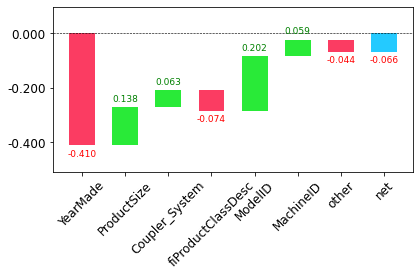

In [78]:
waterfall(valid_xs_final.columns, contributions[0], threshold=0.08, 
          rotation_value=45,formatting='{:,.3f}');

Bu tipten bir bilgi development aşamasından ziyade daha çok production aşamasında kullanılır, kullanıcıların modelin spesifik bir örnek için hangi faktörlere dayanarak ilgili tahmini yaptığını anlamasını sağlayabiliriz.

Bu konuyla birlikte tabular problemi için bazı klasik ML tekniklerini öğrendik, şimdi deep learning'e bakacağız:

## Extrapolation and Neural Networks

Diğer ML veya DL algoritmaları gibi random forests'ın da problemi modelin yeni datayı iyi genellemiyor oluşu. Hangi durumlarda Neural Networks daha iyi generalization sağlıyor buna bakacağız, ancak önce random forests'ın extrapolation problemine bir bakalım.

In [79]:
np.random.seed(42)

Basit bir task olsun, 40 data points'i baz alarak predictions yapmak istiyoruz diyelim. Birazcık noisy linear bir relationship olan bir dataset yaratalım:

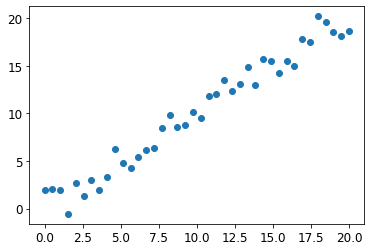

In [80]:
x_lin = torch.linspace(0,20, steps=40)
y_lin = x_lin + torch.randn_like(x_lin)
plt.scatter(x_lin, y_lin);

Bu dataset'i bir random forest modeline besleyerek modeli eğiteceğiz ancak şunu unutmayalım, burada tek bir independent variable'ımız yani feature'ımız olsa dahi, sklearn bizden bir matrix bekler o yüzden modele 40 data point besleyeceksek bu datapoints'in **shape**'i `[40]` değil `[40,1]` olmalı. Bunu yapmanın bir yolu `unsqueeze` methodu, 
Although we only have a single independent variable, sklearn expects a matrix of independent variables, not a single vector. So we have to turn our vector into a matrix with one column. In other words, we have to change the *shape* from `[40]` to `[40,1]`. One way to do that is with the `unsqueeze` method, bu method tensor'e belirtilen dimension'da yeni bir axis ekler.

In [81]:
#Shape'i 1D'den 2D'ye çevirdik, model bu yapıyı bekliyor.
xs_lin = x_lin.unsqueeze(1)
x_lin.shape,xs_lin.shape

(torch.Size([40]), torch.Size([40, 1]))

Aşağıda bu işlemi yapmanın faha flexible bir yöntemi gösterilmiş. Slice an array or tensor with the special value `None`, which introduces an additional unit axis at that location:

In [82]:
x_lin[:,None].shape

torch.Size([40, 1])

Şimdi elimizdeki 40 datapoint'in ilk 30'unu kullanarak bir model eğiteceğiz:

In [83]:
m_lin = RandomForestRegressor().fit(xs_lin[:30],y_lin[:30])

Modelimizi eğittik, şimdi tüm dataset için modelin tahminleri ile dataset'i aynı plot üzerinde görelim:

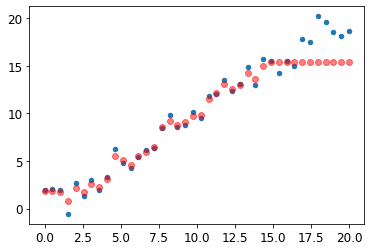

In [84]:
plt.scatter(x_lin, y_lin, 20)
plt.scatter(x_lin, m_lin.predict(xs_lin), color='red', alpha=0.5);

Yukarıdaki plot çok önemli bir phenomenon'u ortaya çıkarıyor, random forest modelimiz eğitimin yapıldığı feature range'i içerisinde gayet başarılı sonuçlar verirken, daha önce görmediği ve eğitim range'inin dışına çıkan datapoints için afallıyor.

Bu neden böyle oluyor? Cevabı gayet açık, çünkü random forest modelinin temeli, yeni gelen data point'i binary sorular ile training set içerisindeki spesifik bir gruba dahil etmek. Yani yeni gelen datayı tranining setteki bir group of data ile eşliyor, prediction değeri de bu group of data'nın average'ı olacak. Yani bir tree veya random forest modelinin, training set içerisindeki target range'inden daha yüksek veya düşük bir prediction yapması olası değil. İMKANSIZ. 

Tekrar söylüyorum, modelim altında yatan tüm mantık zaten gelen yeni datapoint'e sanki training setteki bir başka datapoint'miş (veya en azından bir gruba dahilmiş) gibi davranması. Model eğitilirkeni training set datasını olabildiğince anlamlı şekilde binary sorularla gruplara bölüyor öyle ki yeni veriler bu gruplardan birine dahil edildiğinde ve o grubun ortalaması prediction olarak verildiğinde gruba bölünmediği halden daha az hata elde ediliyor. Zaten hatırlarsan, eğer bir tree'ye sınır koymazsak, nerdeyse her grup tek bir data'dan oluşana kadar bölme işlemi yapıyordu, o halde de training set'teki her datapoint için tam da doğru sonucu verecek, yani training error 0 olacaktır ancak bu durumda generalization kabiliyetini kaybediyor.

A tree and a random forest can never predict values outside of the range of the training data. This is particularly problematic for data where there is a trend over time, such as inflation, and you wish to make predictions for a future time.. Your predictions will be systematically too low.

Burada range derken ben target range'den bahsediyordum ama aslına bakarsan, feature range, target range'in sebebi. Çünkü şöyle düşün yukarıdaki datasette eğer yeni gelen datapoints training setteki feature ile aynı range de ise (0-15) arası o halde, modelimizi doğru tahmin yapacaktır, elbette modelimiz en yine en fazla target range kadar bi tahmin yapabilir ama zaten eğer training set doğru seçilmişse bu aralıktaki bir dataset için target range dahilinde kalacaktır.

Yani probleme yol açan şeye target'ın range dışında olması olarak bakmak yerine, yeni data'nın feature'larının training data feature'larının range'ı dışında olması olarak bakılabilir. Bunu şöyle düşün, mesela training set içerisinde feature olarak bir değer 10-20 arasında değişmiş, yeni gelen data 10'dan küçük veya 20'den büyükse, model bunun için extrapolation yapamıyor, ona sanki 10'muş veya sanki 20'ymiş gibi davranıyor, çünkü sonuçta sorulara verdiği cevaplara göre gruba atama yapıyor.

İşte modelin bu özelliğinden dolayı RANDOM FOREST MODELLERİ İÇİN VALIDATION, TEST VEYA REAL LIFE DATA'NIN OUT-OF-DOMAIN DATA İÇERMEDİĞİNDEN EMİN OLMALIYIZ. Yani modele eğitim sonrası beslenebilecek her veri, eğitim seti'nin range'i içerisinde olmalı ki model sağlıklı tahminler yapabilsin.

Yukarıdaki grafiğe benzer şekilde time-series verilerde geleceği tahmin etmek istediğimiz için, veriler geçmişteki tüm verilerden düşük veya yüksek olabilir işte bu durumlarda, problem yaşayacağız.


### Finding Out-of-Domain Data

Yukarıda açıklanan concept gözetildiğinde, biz validation set'in out of domain data içerip içermediğini anlamak isteriz, şayet eğer içeriyorsa modelimiz iyi sonuçlar vermeyecektir. Hatırlarsan, daha önce tree için OOB error'dan bahsetmiştik ve bu error, validation error'u temsil etmesine rağmen ondan düşük çıkıyordu, işte belki de sebebi buydu, validation set içerisinde out-of-domain data olduğu için, model bunu sınıflandırdığında extrapolation yapamıyor, dolayısıyla olması gerekenden yüksek validation errors elde ediyoruz.

Bu noktada eğer biz bu out of domain data'ya yol açan column'u tamamen ortadan kaldırırsak daha iyi bir generalization sağlamamız mümkün. Yani diyelim ki tek bir feature için training set 0-10 arasındaki iken, validation sette birsürü data için bu feature 10'dan büyük, o halde bu feature'ı modelde kullanmak bize faydadan çok zarar getiriyor çünkü bu feature kullanılarak verilen kararlarda modelin extrapolation yeneteği olmadığı için çok büyük trim'ler yapmak zorunda kalıyor bu da büyük hata demek.

Eğer biz bu feature'ı tespit edip tamamen datasetten silersek, validation set içerisinde out of domain data diye bir derdimiz olmayacak, çünkü onu out of domain yapan feature artık yok.

İyi güzel buraya kadar tamam ama, training set ile validation set arasında fark yaratan, validation set'i out of domain yapan feauture'ları nasıl tespit edebiliriz ki?

Random Forest kullanarak! Yapacağımız iş şu, training set ile validation set'i concat edeceğiz, tek bir dataset elde edeceğiz, her bir row'un target'ı olarak eski target değil de ilgili row'un training data m yoksa validation data mı olduğunu gösterecek.

Şimdi böyle bir dataset için bir random forest eğittiğimizde, random forest'ın amacı her bir row için bu row'un training'e mi yoksa validation set'e mi ait olduğunu tahmin etmek, normal şartlarda sağlıklı veriseti için bu ayrımın yapılabilmesini istemeyiz, eğer bu ayrım yapılıyorsa out of domain dataset olarak düşünülebilir.

İşte eğitilen modelin, en önemli feature'larına bakarsak, training set ile validation set'i farklılaştıran en önemli column'ları bulmuş oluruz, bu column'ları silersek out of domain data'dan da kurtulmuş oluruz.

In [85]:
df_dom = pd.concat([xs_final, valid_xs_final])
is_valid = np.array([0]*len(xs_final) + [1]*len(valid_xs_final))

m = rf(df_dom, is_valid)
rf_feat_importance(m, df_dom)[:6]

,cols,imp
6,saleElapsed,0.892062
9,SalesID,0.091254
14,MachineID,0.012449
0,YearMade,0.001342
16,Tire_Size,0.000498
3,fiProductClassDesc,0.000426


Training ve Validation sets'i ayırmaya çalışan model için, yukarıdaki ilk üç column diğerlerine kıyasla bariz daha fazla önem teşkil ediyor. Bu şu demek, yukarıdaki ilk üç column değerleri training ve validations sets arasında bariz farklılık gösteriyor. 

saleElapsed ve salesID ve MachineID column'ları büyük ihtimalle, zamana bağlı değişkenler yani zaman geçtikçe artıyorlar, işte bu sebepten, training set ile validation set arasında bu column'lar bariz farklı değerler alıyor, bu durum istemediğimiz bir durum.

İşte bu sebepten bu column'ları tek tek kaldırırsak bunun sonuca etkisinin ne olacağına bakalım:

In [86]:
m = rf(xs_final, y)
print('orig', m_rmse(m, valid_xs_final, valid_y))

for c in ('SalesID','saleElapsed','MachineID'):
    m = rf(xs_final.drop(c,axis=1), y)
    print(c, m_rmse(m, valid_xs_final.drop(c,axis=1), valid_y))

orig 0.231575
SalesID 0.229837
saleElapsed 0.235885
MachineID 0.231264


Görünüşe göre `SalesID` ve `MachineID` column'larını remove etmek bir accuracy kaybına neden olmuyor. Şimdi ikisini birden remove edelim, böyle bir model eğitelim ve sonuca bakalım:

In [87]:
time_vars = ['SalesID','MachineID']
xs_final_time = xs_final.drop(time_vars, axis=1)
valid_xs_time = valid_xs_final.drop(time_vars, axis=1)

m = rf(xs_final_time, y)
m_rmse(m, valid_xs_time, valid_y)

0.229341

Görüdğümüz gibi, bu değişkenleri remove etmek model accuracy'sini birazcık arttırdı daha önemlisi modeli daha dirençli hale getirdi, ve modelin sürdürülebilirliğini ve anlaşılmasını kolaylaştırdı.


We recommend that for all datasets you try building a model where your dependent variable is `is_valid`, like we did here. It can often uncover subtle *domain shift* issues that you may otherwise miss.

Modelimizi biraz daha iyileştirebilecek bir diğer etken ise, eski data'yı kullanmaktan kaçınmak olabilir. Eski verilerle eğitilen modeller, artık geçerli olmayan ilişkiler yakalamış olabilir bu da sonucu kötü yönde etkiler. Bu yüzden sadece son yılların verisini ayırarak, modeli bu veri ile eğitmeyi deneyelim.

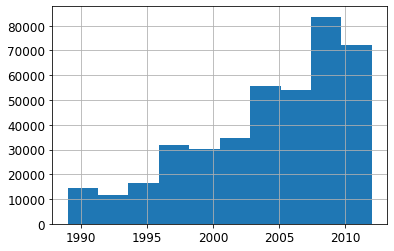

In [88]:
xs['saleYear'].hist();

2004'ten sonrası için eğitilen model aşağıdaki gibi:

In [89]:
filt = xs['saleYear']>2004
xs_filt = xs_final_time[filt]
y_filt = y[filt]

In [90]:
m = rf(xs_filt, y_filt)
m_rmse(m, xs_filt, y_filt), m_rmse(m, valid_xs_time, valid_y)

(0.177425, 0.228149)

Göründüğü üzere bir tık daha iyi bir sonuç. Bu da gösteriyor ki her zaman tüm dataset'i kullanmamız gerekmez, hatta bazen kullanmamamız daha iyi olabilir. 

Kalan kısımda tabular datasets için neural networks kullanacağız.

### Using a Neural Network

Bir neural network modeli oluşturmak için aynı yaklaşımı kullanabiliriz. Öncelikle daha önce `TabularPandas` objesini oluşturmak için yapılanları tekrar yapalım:

In [91]:
df_nn = pd.read_csv(path/'TrainAndValid.csv', low_memory=False)
df_nn['ProductSize'] = df_nn['ProductSize'].astype('category')
df_nn['ProductSize'].cat.set_categories(sizes, ordered=True, inplace=True)
df_nn[dep_var] = np.log(df_nn[dep_var])
df_nn = add_datepart(df_nn, 'saledate')

Yukarıda ne yaptık, df_nn içerisine training ve validation datasını çektik, ardından, ProductSize feature'ı ordinal olduğu için, daha önce olduğu gibi order belirttik, daha sonra, target'ın logarithm'i alındı. Sonra da saledate column'u add_datepart fonksiyonu ile zenginleştirildi. 

Random forest için yaptığımız analizler sonucunda bazı columns'u kesmiştik, bunlar önemsiz columnlar, dependent columnlar ve out of range data'ya neden olan columnlardı. Şimdi aynı column'ları tekrar keseceğiz, NN için de bu temizlenmiş dataset'i kullanacağız:

In [92]:
df_nn_final = df_nn[list(xs_final_time.columns) + [dep_var]]

Random Forest modeli için categorical columns için ekstra bir işlem yapılmamıştı, numeric categoricals olarak temsil ediliyordu, forest split point olarak categorical kullanırsa, ilgili feature'ın belirli bir kategoriye eşit olup olmadığına bakıyordu.

Neural networks için ise, categorical variables ile ilgilenmek için elimizde çok iyi bir tool var: Embeddings. Zaten anladığım kadarıyla, tabular data için, deep learning yaklaşımının öne geçebildiği noktada bu, eğer high cardinality categorical variables sayısı fazla ise, random forest modeli çok iyi sonuçlar veremeyebiliyor.

Embeddings'i yaratabilmemiz için, fastai'ın hangi column'ların categorical olduğunu bilmesi gerek. Bunu yapabilmek için ilgili variable'ın kaç farklı distinct levels'i olduğuna bakılır, eğer ilgili feature `max_card` parametresinden daha az distinct levels içeriyorsa bu feature categorical olarak ele alınır.

Embedding sizes larger than 10,000 should generally only be used after you've tested whether there are better ways to group the variable, so we'll use 9,000 as our `max_card`:

In [93]:
cont_nn,cat_nn = cont_cat_split(df_nn_final, max_card=9000, dep_var=dep_var)

Burada, bizim kesinlikle categorical olarak ele almak istemediğimiz bir feature var o da `saleElapsed` feature'ı. Bu feature bir nevi tarihi gösterir, yani zamanla artar, e bunu categorical olarak belirlersek, yeni datapoints yeni tarih değeri alamayacaktır, bu değerin continous kalması gerek. Çünkü gelecekteki verileri tahmin etmek isteyeceğiz.

Aşağıdaki şekilde, column ismini continious değişkenler arasına kaydedirken, categoricals arasından çıkarıyoruz.

In [94]:
cont_nn.append('saleElapsed')
cat_nn.remove('saleElapsed')

Bu değişkeni continious variable olarak kullanabilmek için, numeric tipte olduğundan emin olmalıyız string olursa bunu yapamayız:

In [95]:
df_nn['saleElapsed'] = df_nn['saleElapsed'].astype(int)

Şimdi belirlenen categorical variables için cardinality değerlerine bakalım, max_card parametresi 9000 olarak atandığı için 9000'den düşük cardinality'li her feature categorical olarak ele alındı. Max_card default olarak 20 idi.

In [96]:
df_nn_final[cat_nn].nunique()

YearMade                73
ProductSize              6
Coupler_System           2
fiProductClassDesc      74
Hydraulics_Flow          3
ModelID               5281
fiSecondaryDesc        177
fiModelDesc           5059
Enclosure                6
Hydraulics              12
fiModelDescriptor      140
ProductGroupDesc         6
Drive_System             4
Tire_Size               17
dtype: int64

Yukarıda ModelID ve fiModelDesc feature'larının ikisinin de hem çok yüksek hem de benzer cardinality değerlerine sahip olduğunu görüyoruz. Bu durum bu iki column'un benzer ve gereksiz bilgi taşıdığı anlamına gelebilir.

Bu iki column'un dependent olduğunu redundant feature analizi yaparken göremeyebiliriz. We would not necessarily see this when analyzing redundant features, since that relies on similar variables being sorted in the same order (that is, they need to have similarly named levels). Yani anladığım kadarıyla rendundancy analizden rank-correlation gibi bir yöntemle similarity hesaplanıyor ve bu yöntemle yukarıdaki gibi iki high cardinality dependent features tespit edilemeyebiliyor.

5000 leveli olan bir categorical variable için 5000xembd_size'lık bir embedding matrix tutulmak zorunda, avoid edebilirsek gayet iyi olur. Bakalım, bu değişkenlerden birini silmek model üzerinde önemli bir değişikliğe neden oluyor mu?

In [97]:
xs_filt2 = xs_filt.drop('fiModelDescriptor', axis=1)
valid_xs_time2 = valid_xs_time.drop('fiModelDescriptor', axis=1)
m2 = rf(xs_filt2, y_filt)
m_rmse(m2, xs_filt2, y_filt), m_rmse(m2, valid_xs_time2, valid_y)

(0.176853, 0.229973)

Gördüğümüz gibi, ilgili column'u atıp, modeli tekrar eğittiğimizde modelin validation error'unda çok hafif bir değişim söz konusu o halde boşu boşuna bu feature'ı tutmaya gerek yok.

Bu feature'ı categorical variables içerisinden silelim:

In [98]:
cat_nn.remove('fiModelDescriptor')

Sırada aynen random forest modeli için oluşturduğumuz gibi bir `TabularPandas` object oluşturmak var, ancak buna önemli bir ekleme yapacağız o da **normalization**. Random forest, çalışma prensibi gereği bir normalization'a gerek duymaz onun için önemli olan order of values in a variable! Scale önemli değil. 

Ancak bildiğimiz gibi neural network için feature scaling önemli, farklı features arasında farklı scalings olması, cost function'ın istenmeyen formlarda olmasına neden oluyor bu da optimisation'ı oldukça yavaşlatıyor.

Bu yüzden `TabularPandas` objemize `Normalize` processor'ını da ekliyoruz. Hatırlarsak processors sanki transforms gibiydi.

Sonuç olarak, ilgili procs'u TabularPandas objesine, dataset, categorical ve continous variable list, dep. var ve ids daha önce olduğu gibi besleniyor. Bunun sonucunda bir TabularPandas objesi elde edeceğiz, istersek bu model ile doğrudan bir Random Forest modeli eğitebiliyorduk, ancak bizim burada amacımız bir NN eğitmek o halde, bu objeden bir dataloaders elde edeceğiz.

In [112]:
df_nn_final.dtypes

YearMade                 int64
ProductSize           category
Coupler_System          object
fiProductClassDesc      object
Hydraulics_Flow         object
ModelID                  int64
saleElapsed              int64
fiSecondaryDesc         object
fiModelDesc             object
Enclosure               object
Hydraulics              object
fiModelDescriptor       object
ProductGroupDesc        object
Drive_System            object
Tire_Size               object
SalePrice              float64
dtype: object

Burada bir hata vardı, gördüğümüz gibi saleElapsed continious bir variable, yani normalize edilmeli, ancak tipine bakarsak object yani string tipinde olduğunu göreceğiz, aşağıdaki satır ile, bu column'u numeric hale getiririz ve yolumuza öyle devam ederiz:

In [114]:
df_nn_final = (df_nn_final[list(xs_final_time.columns) + [dep_var]]).copy()
df_nn_final.dtypes

YearMade                 int64
ProductSize           category
Coupler_System          object
fiProductClassDesc      object
Hydraulics_Flow         object
ModelID                  int64
saleElapsed              int64
fiSecondaryDesc         object
fiModelDesc             object
Enclosure               object
Hydraulics              object
fiModelDescriptor       object
ProductGroupDesc        object
Drive_System            object
Tire_Size               object
SalePrice              float64
dtype: object

In [111]:
procs_nn = [Categorify, FillMissing, Normalize]
to_nn = TabularPandas(df_nn_final, procs_nn, cat_nn, cont_nn,
                      splits=splits, y_names=dep_var)

TabularPandas modeli oluşturuldu. Tabular models genelde çok GPU RAM'i gerektirmez o yüzden görece büyük batch sizes kullanabiliriz, dataloaders elde edilsin:

In [115]:
dls = to_nn.dataloaders(1024)

Daha önce yaptığımız gibi, regression modelleri için learner yaratırken `y_range` set etmek mantıklı olacaktır, hatırlarsan bunun tek yaptığı model çıkışına bir layer ekleyerek çıkışı belirli bir range arasında tutmaktı o kadar. 

Bu range'i bulabilmek için training set içerisinde target'ımızın min ve max'ına bakalım:

In [116]:
y = to_nn.train.y
y.min(),y.max()

(8.465899, 11.863583)

Şimdi sırada, tabular modelimizi yaratmak için learner objesini kullanmak var. Daha önce olduğu gibi  tabular uygulamalar için de application specific learner'ımız var, bu learner'lar default ayarları ile uygulama bazlı işimizi kolaylaştırır. Loss function'ı MSE olarak set ediyoruz.

Default olarak tabular learner 200 ve 100 activations ile 2 hidden layers yaratır, small datasets için bu boyutta bir model gayet iyi çalışır, ancak daha büyük datasets için daha büyük bir model kullanmak daha iyi olacaktır, bu örnek için 500 ve 250'lik 2 hidden layers kullanılıyor:

In [121]:
learn = tabular_learner(dls, y_range=(8,12), layers=[500,250],
                        n_out=1, loss_func=F.mse_loss)

SuggestedLRs(lr_min=0.003981071710586548, lr_steep=0.0002290867705596611)

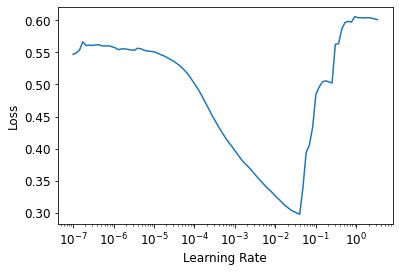

In [122]:
learn.lr_find()

Transfer learning söz konusu olmadığı için `fine_tune` kullanılmayacak, modeli `fit_one_cycle` ile eğiteceğiz, 5 epoch için sonuca bi bakalım:

In [125]:
learn.fit_one_cycle(5, 1e-2)

epoch,train_loss,valid_loss,time
0,0.057728,0.064801,00:08
1,0.051663,0.055334,00:08
2,0.046009,0.054506,00:08
3,0.042067,0.051799,00:08
4,0.039640,0.051563,00:08


Random forest modeli ile sonuçları karşılaştırmak için r_mse fonksiyonunu kullanabiliriz:

In [126]:
preds,targs = learn.get_preds()
r_mse(preds,targs)

0.227075

It's quite a bit better than the random forest (although it took longer to train, and it's fussier about hyperparameter tuning).

Before we move on, let's save our model in case we want to come back to it again later:

In [127]:
learn.save('nn')

Path('models/nn.pth')

### Sidebar: fastai's Tabular Classes

Fastai'da **tabular model** basitçe continious veya categorical columns olan bir data için category (classification model) veya continious value (regression model) tahmin eden bir modeldir. Categorical independent variables, collaborative filtering örneğinde gördüğümğüz gibi embedding layer'dan geçirilir ve daha sonra concatenate edilir, bu concatanetas sonuca continous variables da eklenir ve en nihayetinde bir embeddings'leride içinde bulunduğu bir input layer, model yaratılırken belirtilen hidden layers'a beslenir ve sonucunda problem tipine göre discrete veya continous output beklenir.


The model created in `tabular_learner` is an object of class `TabularModel`. Take a look at the source for `tabular_learner` now (remember, that's `tabular_learner??` in Jupyter). You'll see that like `collab_learner`, it first calls `get_emb_sz` to calculate appropriate embedding sizes (you can override these by using the `emb_szs` parameter, which is a dictionary containing any column names you want to set sizes for manually), and it sets a few other defaults. Other than that, it just creates the `TabularModel`, and passes that to `TabularLearner` (note that `TabularLearner` is identical to `Learner`, except for a customized `predict` method).

That means that really all the work is happening in `TabularModel`, so take a look at the source for that now. With the exception of the `BatchNorm1d` and `Dropout` layers (which we'll be learning about shortly), you now have the knowledge required to understand this whole class. Take a look at the discussion of `EmbeddingNN` at the end of the last chapter. Recall that it passed `n_cont=0` to `TabularModel`. We now can see why that was: because there are zero continuous variables (in fastai the `n_` prefix means "number of," and `cont` is an abbreviation for "continuous").

### End sidebar

Generalization için işimize yarayabilecek bir başka şey, random forest'ın özünde yatan fikir gibi, birden fazla model kullanıp bunların predictionlarının average'ını overall prediction olarak kullanmaktır. Daha önce de bahsettiğimiz gibi bu yönteme **ensembling** denir.

## Ensembling

Random forests'ın neden iyi çalıştığını hatırlarsak, her tree'nin hataları oluyordu ancak bu hatalar birbirleri ile correlated olmadığı için tree tahminlerinin ortalamalarını alırken bu hatalar birbirlerini cancel out ediyordu ve sonucunda gerçek değere çok yakın tahminler üretebiliyorduk.

Bu yaklaşımı decision trees yerine başka algoritmalar için de kullanabiliriz, sonuçta arkaplanda yatan fikir aynı.

Şuan bizim elimizde bir random forest modeli bir de neural network modeli var, bu iki modelin prediction ortalamasını almak bile bize daha iyi sonuç vermeli sonuçta bu iki modelin hataları correlated olmayacak.

Yani random forest modelinin kendisi bir ensemble olsa da biz bu ensemble'ı bir başka ensemble'ın bir üyesi olarak kullanabiliriz. While ensembling won't make the difference between a successful and an unsuccessful modeling process, it can certainly add a nice little boost to any models that you have built.

Burada dikkat etmemiz gereken bir nokta şu ki, PyTorch modeli ile sklearn modelinin output tipi birbirinden farklıdır, PyTorch yani NN modeli rank-2 tensor outpur verirken, sklearn modeli bize rank-1 numpy error output olarak verir. 

Bu conflict'i `squeeze` methodunu kullanarak çözebiliriz, `squeeze` removes any unit axes from a tensor, and `to_np` converts it into a NumPy array:

In [133]:
rf_preds = m.predict(valid_xs_time)
ens_preds = (to_np(preds.squeeze()) + rf_preds) /2

ens_preds içerisinde NN modeli ve Forest modelinin average'ı tutuluyor, sonuçlaraka bakalım:

In [134]:
r_mse(ens_preds,valid_y)

0.222122

Sonucumuz gayet iyi, aslına bakarsan, bu sonuç Kaggle leaderboard'daki herkesten daha iyi, ancak yarışma sonuçlandığı için test seti üzerindeki gerçek performansımızı göremiyoruz.

### Boosting

Şimdiye kadar ensembling yaklaşımı için **bagging** kullanıldı, bagging'i hatırlarsak, her biri training set'in farklı subset'lerinde eğitilmiş olan birsürü modelin prediction average'ını alarak modelleri combine etmeye dayanıyordu. Bu yaklaşımı decision trees'e uygularsak, elde edilen yeni ensembled modele **random forest** diyorduk.

Ensembling için, **bagging** dışında bir başka yöntemden daha söz edebiliriz: **boosting**, boosting için alt modellerin tahmin ortalamasını almak yerine, tahminlerini toplarız. Boosting şöyle çalışır:

- 
- Train a small model that underfits your dataset.
- Calculate the predictions in the training set for this model.
- Subtract the predictions from the targets; these are called the "residuals" and represent the error for each point in the training set.
- Go back to step 1, but instead of using the original targets, use the residuals as the targets for the training.
- Continue doing this until you reach some stopping criterion, such as a maximum number of trees, or you observe your validation set error getting worse.

Using this approach, each new tree will be attempting to fit the error of all of the previous trees combined. Because we are continually creating new residuals, by subtracting the predictions of each new tree from the residuals from the previous tree, the residuals will get smaller and smaller.

To make predictions with an ensemble of boosted trees, we calculate the predictions from each tree, and then add them all together. There are many models following this basic approach, and many names for the same models. *Gradient boosting machines* (GBMs) and *gradient boosted decision trees* (GBDTs) are the terms you're most likely to come across, or you may see the names of specific libraries implementing these; at the time of writing, *XGBoost* is the most popular.

Note that, unlike with random forests, with this approach there is nothing to stop us from overfitting. Using more trees in a random forest does not lead to overfitting, because each tree is independent of the others. But in a boosted ensemble, the more trees you have, the better the training error becomes, and eventually you will see overfitting on the validation set.

We are not going to go into detail on how to train a gradient boosted tree ensemble here, because the field is moving rapidly, and any guidance we give will almost certainly be outdated by the time you read this. As we write this, sklearn has just added a `HistGradientBoostingRegressor` class that provides excellent performance. There are many hyperparameters to tweak for this class, and for all gradient boosted tree methods we have seen. Unlike random forests, gradient boosted trees are extremely sensitive to the choices of these hyperparameters; in practice, most people use a loop that tries a range of different hyperparameters to find the ones that work best.

Harika sonuçlar alabileceğimiz bir diğer yöntem, neural nets ile öğrenilen embeddings'i machine learning modelleri için kullanmaktır.

### Combining Embeddings with Other Methods

Yukarıdaki gibi eğitilen bir Neural Network modelinden, embeddings'i alıp diğer machine learning modelleri için kullanırsak performansın bariz şekilde arttığını göreceğiz. Yani önce bir NN modeli eğitiriz, bu sırada categorical variables için embeddings öğrenilmiş olacak, daha sonra yeni bir ML modeli eğitirken, dataset içerisinde categorical columns yerine eğitilmiş embeddings'i kullanırız.

Aşağıdaki tablo bu yöntemin performansa etkisini gösterir:

<img alt="Embeddings combined with other methods" width="500" id="embedding_mixed" caption="Effects of using neural network embeddings as input to other machine learning methods (courtesy of Cheng Guo and Felix Berkhahn)" src="../images/att_00054.png">

Tabloda mean average percente error (MAPE) değerleri 4 farklı model için verilmiş. Bunlardan üç tanesinden zaten bahsettik. KNN'i de zaten biliyorum, gayet basit temel bir gruplama algoritması. Tablodaki ilk numeric column, ilgili problem için ilgili methodu kullanarak elde edilen hata değerini gösteriyor. 

İkinci numeric column ise, önce categorical embeddings kullanarak bir neural network eğitip, daha sonra bu eğitilen modelin categorical embeddings'ini, ilgili model için kullanılacak dataset'in categorical columns'u ile replace ederek elde edilen sonucu gösterir. 

Gördüğümüz üzere, embeddings kullanımı, her model için inanılmaz bir performans artışı sağlar.

Yani neural networks kullanarak eğitilen embeddings'leri diğer görece basit modellerin bariz iyileştirilmesi için kullanabiliyoruz. Bu embeddings gerçekten büyülü bir şey.

These embeddings need not even be necessarily learned separately for each model or task in an organization. Instead, once a set of embeddings are learned for some column for some task, they could be stored in a central place, and reused across multiple models. In fact, we know from private communication with other practitioners at large companies that this is already happening in many places.

## Conclusion: Our Advice for Tabular Modeling

Sonuç olarak, tabular modeling için iki yaklaşımdan bahsettik: **decision tree ensembles** and **neural networks**. Decision tree ensembles için de iki farklı yöntemden bahsettik: **random forests**, and **gradient boosting machines**. İkisi de gayet etkili fakat ikisinin de bazı tavizleri var:

- *Random forests* are the easiest to train, because they are extremely resilient to hyperparameter choices and require very little preprocessing. They are very fast to train, and should not overfit if you have enough trees. But they can be a little less accurate, especially if extrapolation is required, such as predicting future time periods.

- *Gradient boosting machines* in theory are just as fast to train as random forests, but in practice you will have to try lots of different hyperparameters. They can overfit, but they are often a little more accurate than random forests.

- *Neural networks* take the longest time to train, and require extra preprocessing, such as normalization; this normalization needs to be used at inference time as well. They can provide great results and extrapolate well, but only if you are careful with your hyperparameters and take care to avoid overfitting.

Sonuçta Jeremy şunu öneriyor, analize Random Forest ile başla, bu şekilde güçlü bir baseline elde etmiş oluruz. Daha sonra eğitilen random forest modelini feature selection ve partial dependence analysis için kullanabiliriz ve datamızı daha iyi anlayabiliriz.

Daha sonra, neural nets ya da GBMs eğitmeyi deneyebiliriz, eğer bu modeller bize bariz daha iyi sonuçlar verirse bunları kullanabiliriz, eğer random forest zaten iyi bir sonuç vermişse, o halde neural networks ile elde edilen embeddings'i datasetteki categorical variables'ın yerine yazarak yeni bir random forest modeli eğit böylece performansı iyileştirebilirsin.